In [ ]:
# Importing all the libaries
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import kagglehub


In [ ]:

#  Setup, Here we are using Cuda for better performance, becasue it will use the GPU
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_SIZE = 224
BATCH_SIZE = 64
NUM_CLASSES = 15
EPOCHS = 25
LEARNING_RATE = 1e-4


In [ ]:

#  Simulate Long-Tail Dataset
samples_unbalanced = [800, 700, 625, 550, 500, 450, 425, 400, 375, 350, 325, 300, 200, 100, 50]
path = kagglehub.dataset_download("ankit1743/skyview-an-aerial-landscape-dataset")
dataset_path = os.path.join(path, "Aerial_Landscapes")
class_names = sorted([folder for folder in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, folder))])
class_to_index = {cls: i for i, cls in enumerate(class_names)}

image_paths, labels = [], []
for k, class_name in enumerate(class_names):
    class_dir = os.path.join(dataset_path, class_name)
    images = sorted(os.listdir(class_dir))[:samples_unbalanced[k]]
    for img in images:
        image_paths.append(os.path.join(class_dir, img))
        labels.append(class_to_index[class_name])

In [ ]:
#   Dataset & Transforms
class CustomImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
])

test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

#  we create a dataset and split it into the splits it into the train and test
full_dataset = CustomImageDataset(image_paths, labels)
train_len = int(0.8 * len(full_dataset))
test_len = len(full_dataset) - train_len
train_data, test_data = random_split(full_dataset, [train_len, test_len])
train_data.dataset.transform = train_transforms
test_data.dataset.transform = test_transforms

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, num_workers=2)

In [ ]:
#  Define Model
efficientnet = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)

#  freeze most layers
for param in efficientnet.parameters():
    param.requires_grad = False

# Unfreeze top 5 blocks
for param in efficientnet.features[-5:].parameters():
    param.requires_grad = True

# Custom classifier head
efficientnet.classifier = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(1280, 1024),
    nn.ReLU(),
    nn.BatchNorm1d(1024),
    nn.Dropout(p=0.4),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(p=0.3),
    nn.Linear(512, NUM_CLASSES)
)

efficientnet.to(DEVICE)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 158MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
#  Loss, Optimizer, Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, efficientnet.parameters()), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)


Epoch 1/25: 100%|██████████| 77/77 [00:19<00:00,  4.05it/s]



 Epoch 1/25 - Training Loss: 0.3508

 Classification Report (Epoch 1):
              precision    recall  f1-score   support

 Agriculture       0.98      0.99      0.98       142
     Airport       0.95      0.96      0.96       165
       Beach       0.97      0.99      0.98       128
        City       0.94      0.99      0.96        96
      Desert       0.98      0.93      0.96       103
      Forest       0.97      0.97      0.97        88
   Grassland       0.92      0.95      0.93        91
     Highway       0.97      0.97      0.97        80
        Lake       0.91      0.92      0.92        76
    Mountain       0.90      0.94      0.92        68
     Parking       1.00      0.98      0.99        62
        Port       1.00      1.00      1.00        67
     Railway       0.84      0.84      0.84        32
 Residential       0.95      0.83      0.89        24
       River       0.00      0.00      0.00         8

    accuracy                           0.96      1230
   macro

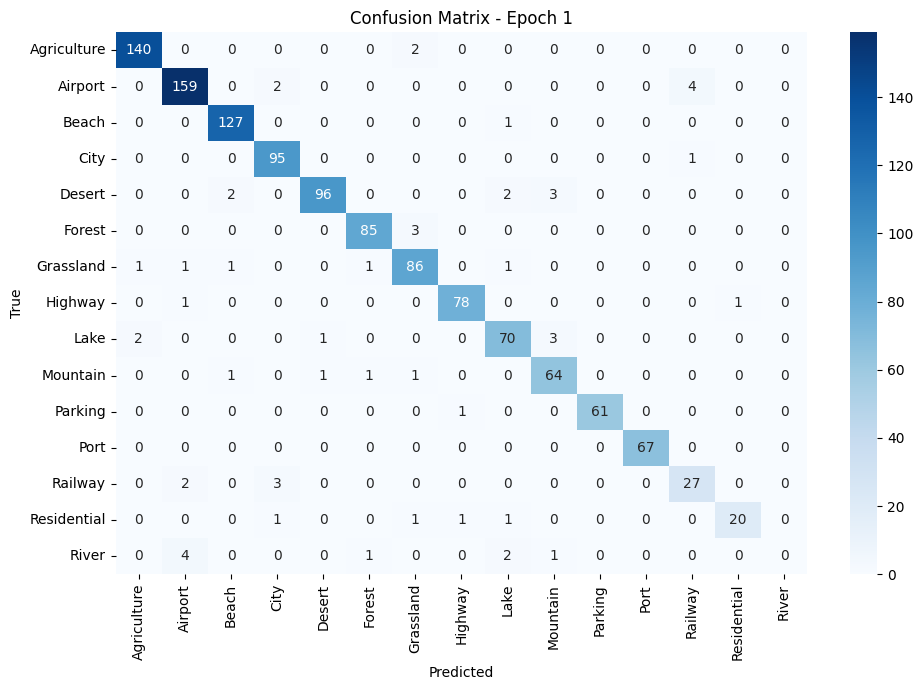

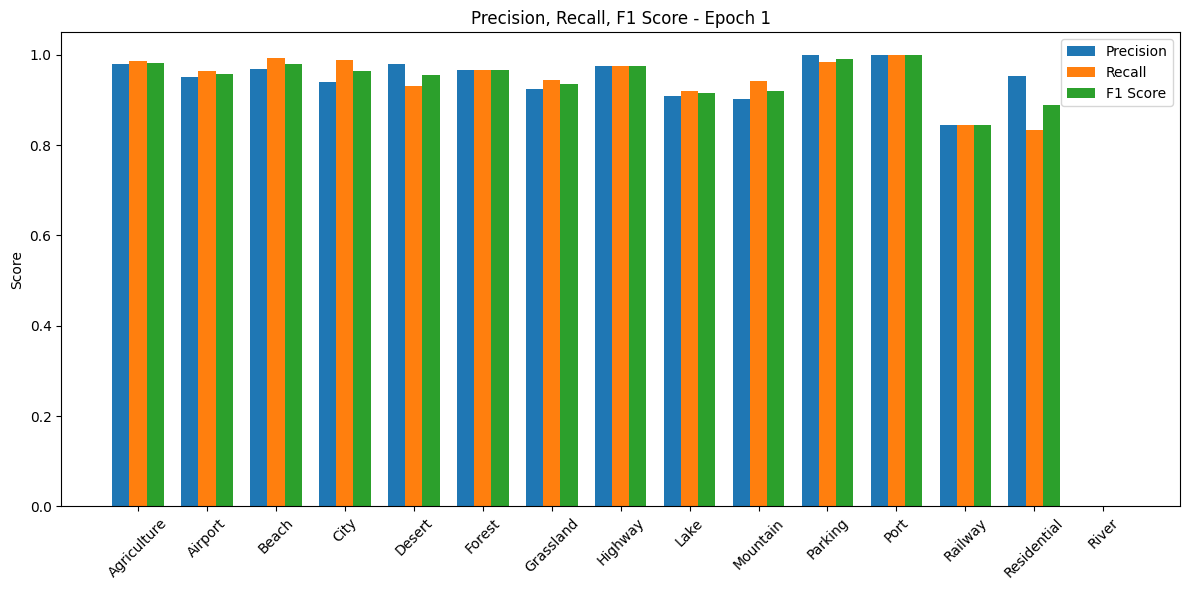

Epoch 2/25: 100%|██████████| 77/77 [00:17<00:00,  4.38it/s]



 Epoch 2/25 - Training Loss: 0.2168

 Classification Report (Epoch 2):
              precision    recall  f1-score   support

 Agriculture       0.98      0.99      0.98       142
     Airport       0.97      0.97      0.97       165
       Beach       0.99      0.98      0.99       128
        City       0.97      0.99      0.98        96
      Desert       0.99      0.95      0.97       103
      Forest       0.99      0.98      0.98        88
   Grassland       0.94      0.96      0.95        91
     Highway       0.97      0.97      0.97        80
        Lake       0.95      0.96      0.95        76
    Mountain       0.92      0.97      0.94        68
     Parking       1.00      1.00      1.00        62
        Port       1.00      1.00      1.00        67
     Railway       0.85      0.88      0.86        32
 Residential       0.96      1.00      0.98        24
       River       1.00      0.25      0.40         8

    accuracy                           0.97      1230
   macro

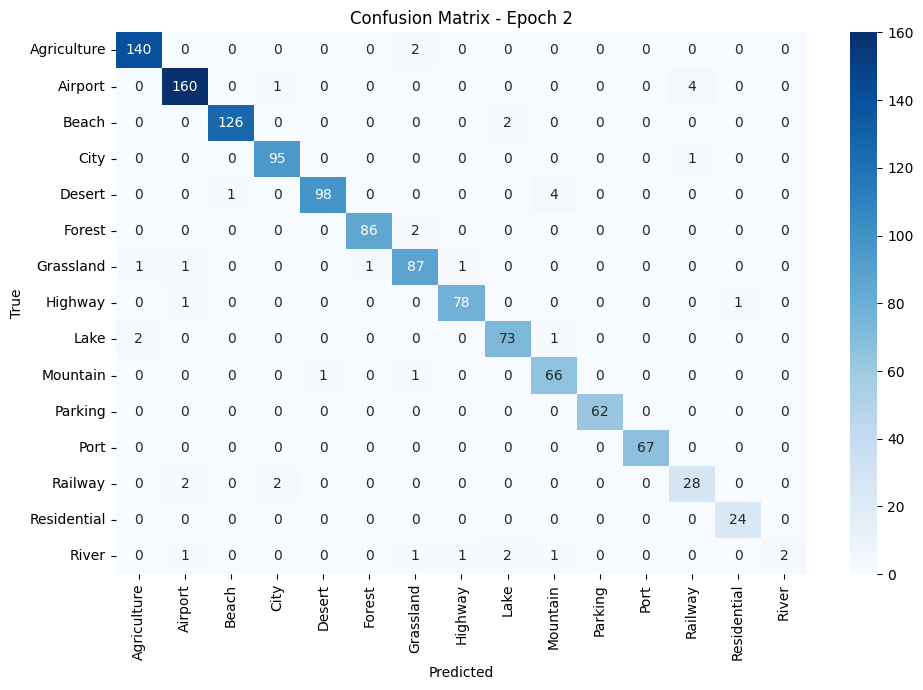

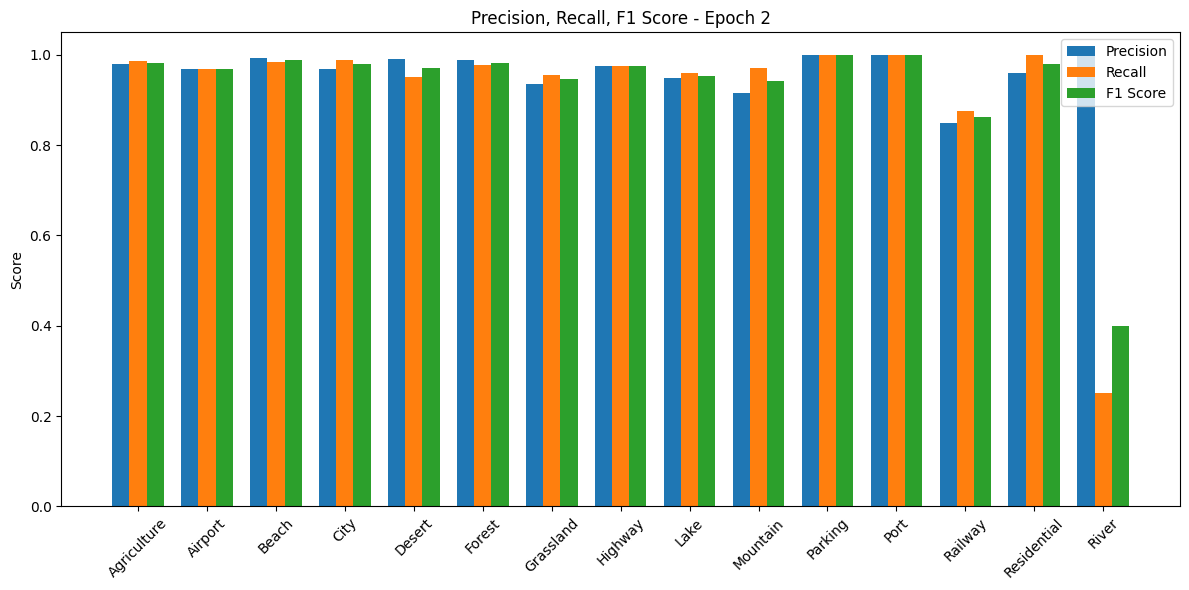

Epoch 3/25: 100%|██████████| 77/77 [00:19<00:00,  4.02it/s]


 Epoch 3/25 - Training Loss: 0.1491



 Classification Report (Epoch 3):
              precision    recall  f1-score   support

 Agriculture       0.98      0.99      0.99       142
     Airport       0.97      0.98      0.98       165
       Beach       1.00      0.98      0.99       128
        City       0.96      0.99      0.97        96
      Desert       0.99      0.96      0.98       103
      Forest       0.99      1.00      0.99        88
   Grassland       0.98      0.96      0.97        91
     Highway       0.96      0.97      0.97        80
        Lake       0.96      0.96      0.96        76
    Mountain       0.92      0.97      0.94        68
     Parking       1.00      1.00      1.00        62
        Port       1.00      1.00      1.00        67
     Railway       0.90      0.84      0.87        32
 Residential       0.96      0.96      0.96        24
       River       1.00      0.50      0.67         8

    accuracy                           0.97      1230
   macro avg       0.97      0.94      0.95  

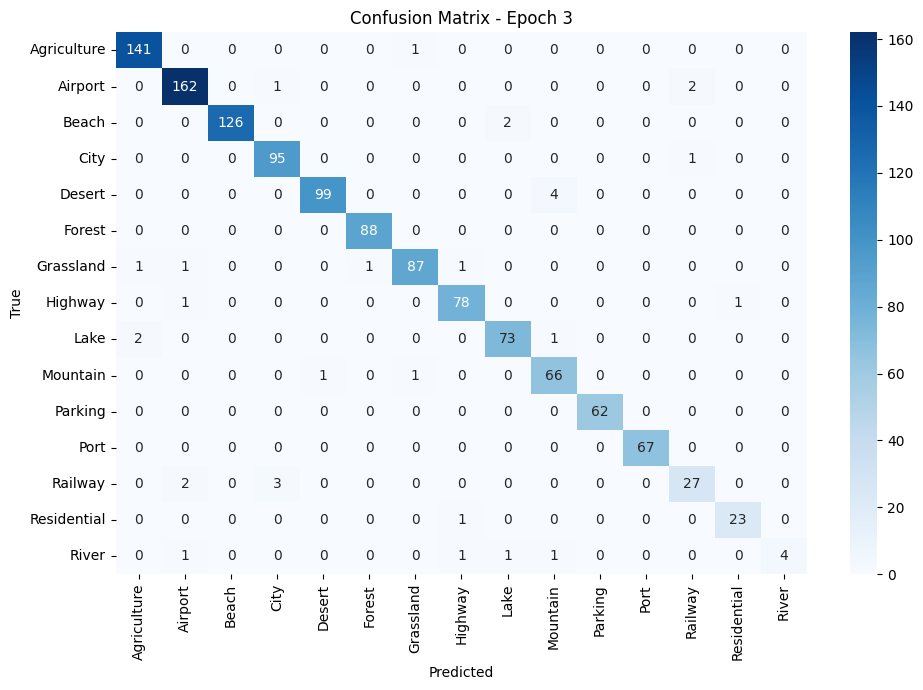

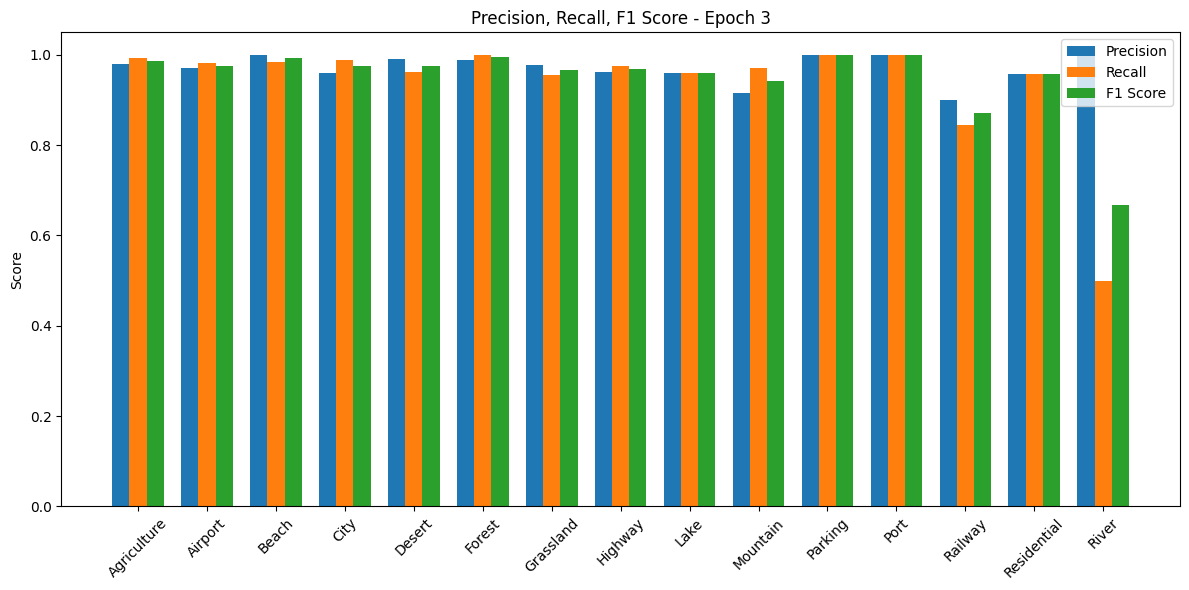

Epoch 4/25: 100%|██████████| 77/77 [00:17<00:00,  4.49it/s]


 Epoch 4/25 - Training Loss: 0.1028



 Classification Report (Epoch 4):
              precision    recall  f1-score   support

 Agriculture       0.98      0.99      0.99       142
     Airport       0.97      0.98      0.97       165
       Beach       0.99      0.99      0.99       128
        City       0.95      0.99      0.97        96
      Desert       0.99      0.98      0.99       103
      Forest       0.98      1.00      0.99        88
   Grassland       0.98      0.95      0.96        91
     Highway       0.99      0.97      0.98        80
        Lake       0.99      0.96      0.97        76
    Mountain       0.94      0.97      0.96        68
     Parking       1.00      1.00      1.00        62
        Port       1.00      1.00      1.00        67
     Railway       0.90      0.84      0.87        32
 Residential       0.96      1.00      0.98        24
       River       1.00      0.62      0.77         8

    accuracy                           0.98      1230
   macro avg       0.97      0.95      0.96  

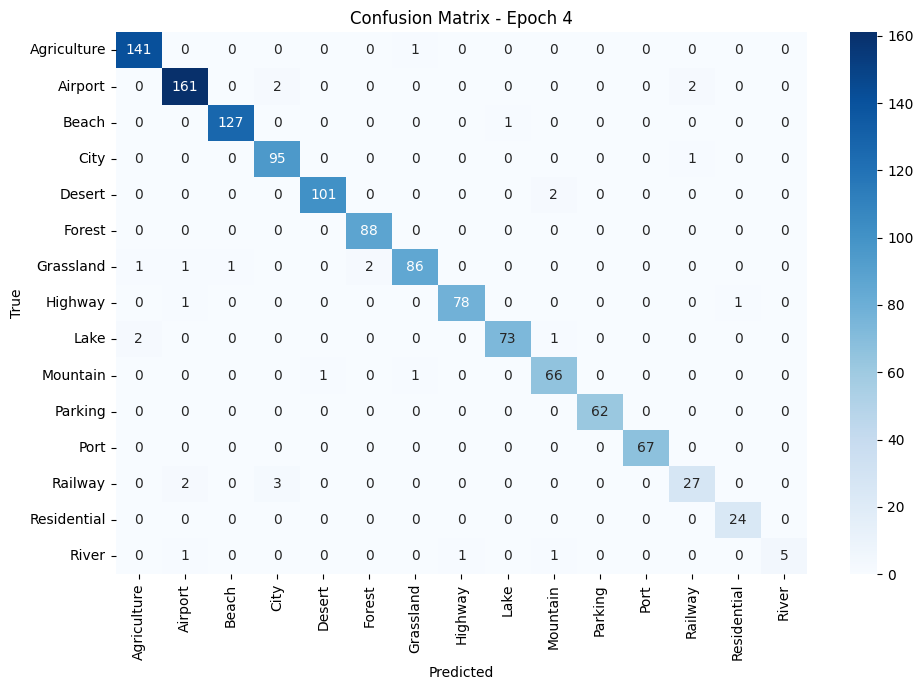

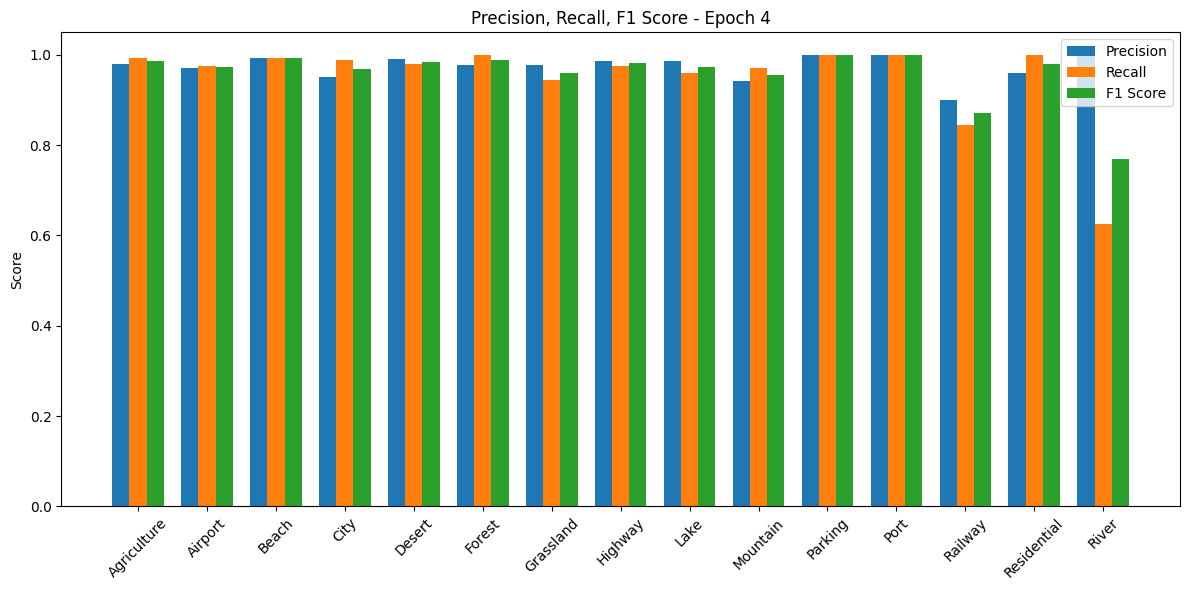

Epoch 5/25: 100%|██████████| 77/77 [00:17<00:00,  4.41it/s]


 Epoch 5/25 - Training Loss: 0.0789



 Classification Report (Epoch 5):
              precision    recall  f1-score   support

 Agriculture       0.99      0.99      0.99       142
     Airport       0.98      0.98      0.98       165
       Beach       1.00      0.99      1.00       128
        City       0.97      0.99      0.98        96
      Desert       0.99      0.98      0.99       103
      Forest       0.98      0.99      0.98        88
   Grassland       0.98      0.95      0.96        91
     Highway       0.99      0.97      0.98        80
        Lake       0.97      0.97      0.97        76
    Mountain       0.96      0.97      0.96        68
     Parking       1.00      1.00      1.00        62
        Port       1.00      1.00      1.00        67
     Railway       0.88      0.91      0.89        32
 Residential       0.96      1.00      0.98        24
       River       0.83      0.62      0.71         8

    accuracy                           0.98      1230
   macro avg       0.96      0.95      0.96  

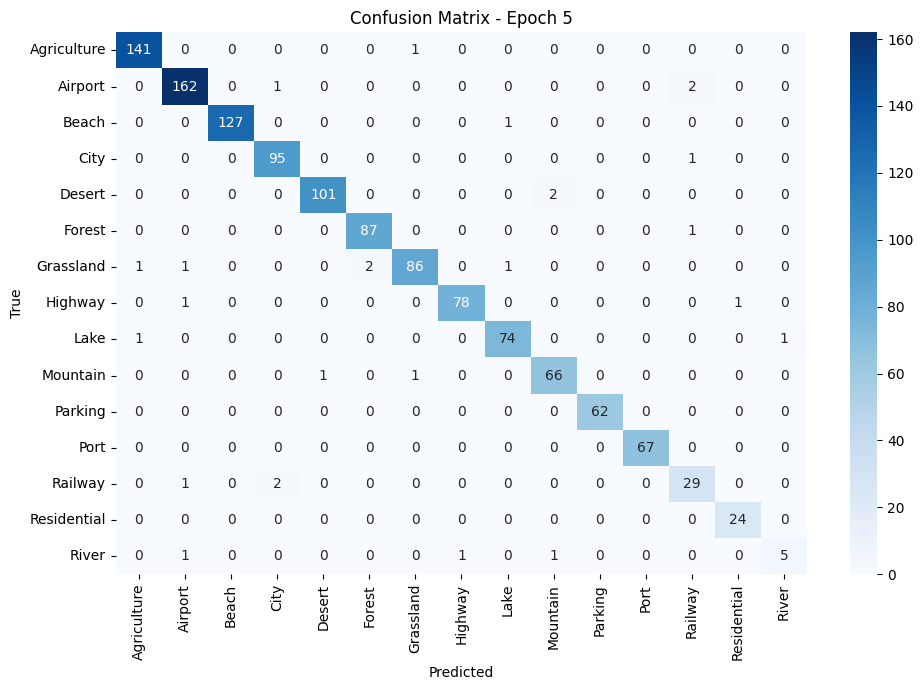

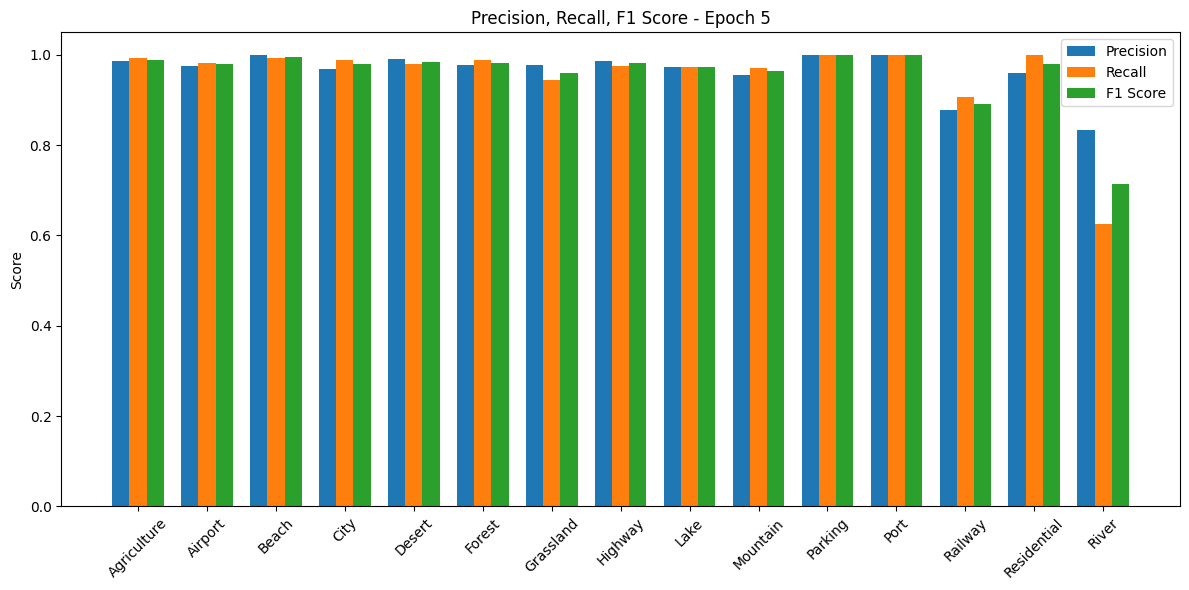

Epoch 6/25: 100%|██████████| 77/77 [00:17<00:00,  4.28it/s]


 Epoch 6/25 - Training Loss: 0.0556



 Classification Report (Epoch 6):
              precision    recall  f1-score   support

 Agriculture       0.99      0.99      0.99       142
     Airport       0.99      0.98      0.98       165
       Beach       0.99      0.99      0.99       128
        City       0.96      0.99      0.97        96
      Desert       0.99      0.96      0.98       103
      Forest       0.98      0.99      0.98        88
   Grassland       0.98      0.95      0.96        91
     Highway       0.96      0.99      0.98        80
        Lake       0.97      0.97      0.97        76
    Mountain       0.94      0.97      0.96        68
     Parking       1.00      1.00      1.00        62
        Port       1.00      1.00      1.00        67
     Railway       0.88      0.88      0.88        32
 Residential       0.96      1.00      0.98        24
       River       0.83      0.62      0.71         8

    accuracy                           0.98      1230
   macro avg       0.96      0.95      0.96  

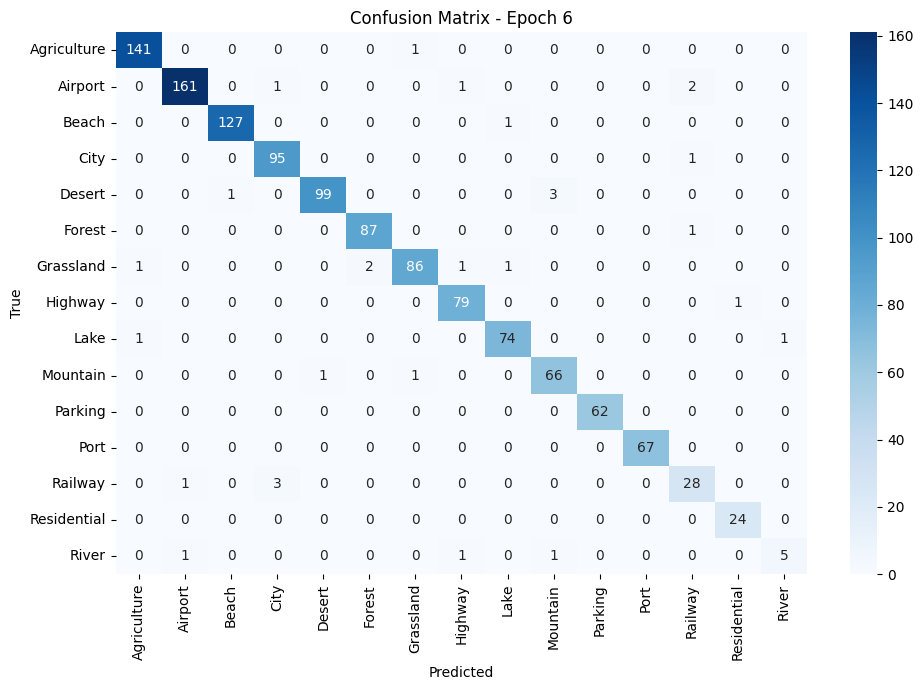

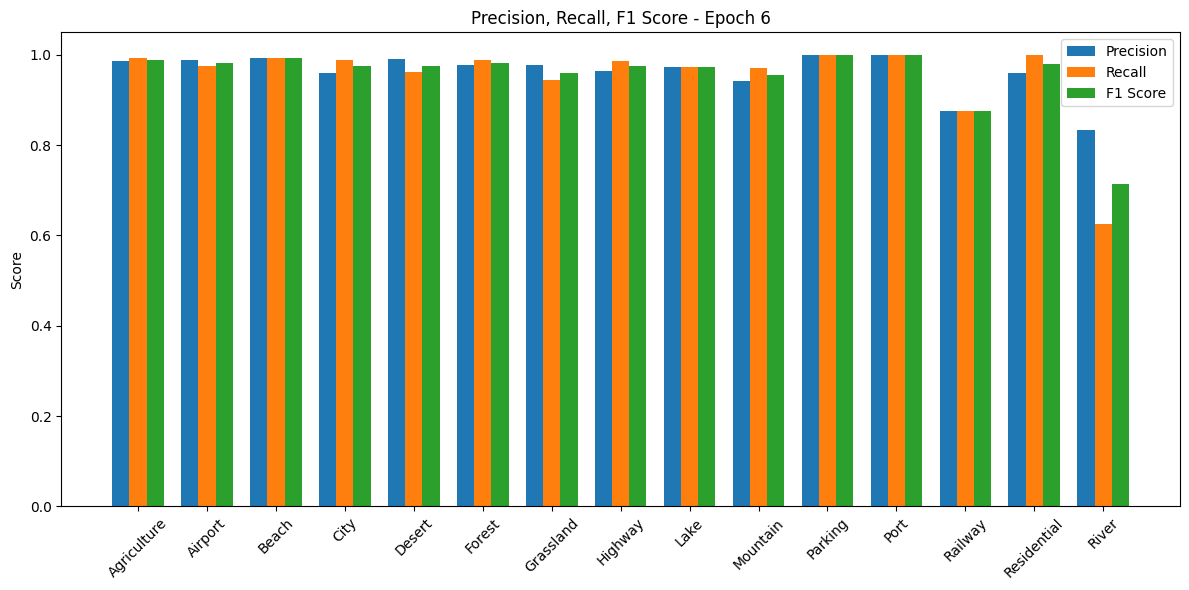

Epoch 7/25: 100%|██████████| 77/77 [00:19<00:00,  4.02it/s]


 Epoch 7/25 - Training Loss: 0.0465



 Classification Report (Epoch 7):
              precision    recall  f1-score   support

 Agriculture       0.99      0.99      0.99       142
     Airport       0.99      0.98      0.98       165
       Beach       0.98      0.99      0.99       128
        City       0.96      0.99      0.97        96
      Desert       0.99      0.97      0.98       103
      Forest       0.99      0.99      0.99        88
   Grassland       0.98      0.97      0.97        91
     Highway       0.98      0.99      0.98        80
        Lake       0.99      0.99      0.99        76
    Mountain       0.94      0.96      0.95        68
     Parking       1.00      1.00      1.00        62
        Port       1.00      1.00      1.00        67
     Railway       0.87      0.84      0.86        32
 Residential       0.96      1.00      0.98        24
       River       1.00      0.75      0.86         8

    accuracy                           0.98      1230
   macro avg       0.97      0.96      0.97  

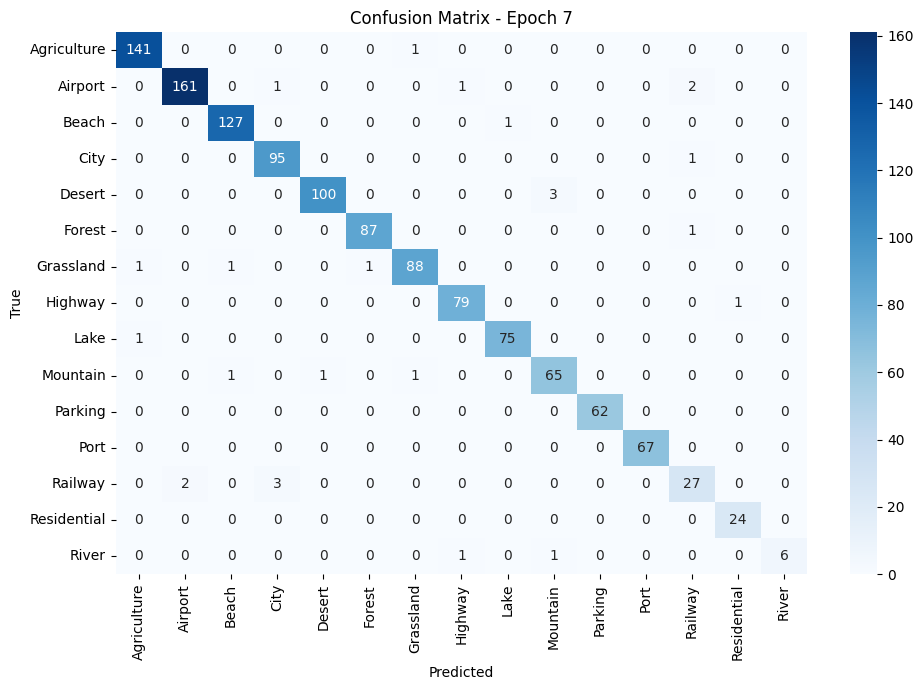

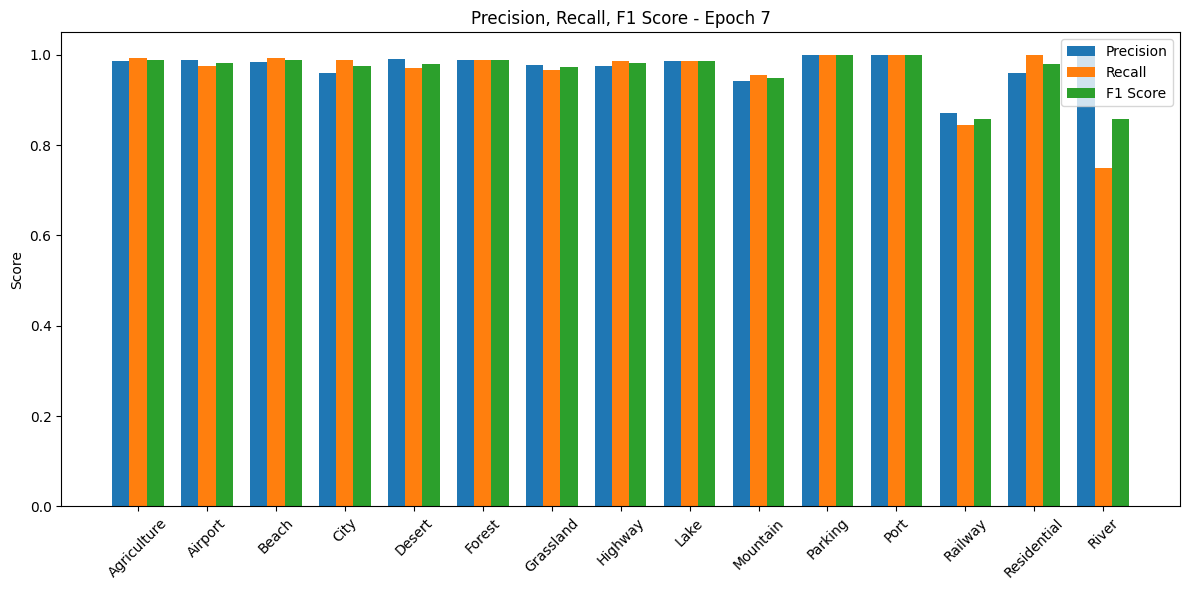

Epoch 8/25: 100%|██████████| 77/77 [00:19<00:00,  3.87it/s]


 Epoch 8/25 - Training Loss: 0.0408



 Classification Report (Epoch 8):
              precision    recall  f1-score   support

 Agriculture       0.99      0.99      0.99       142
     Airport       0.99      0.98      0.98       165
       Beach       0.99      0.99      0.99       128
        City       0.98      0.99      0.98        96
      Desert       0.99      0.98      0.99       103
      Forest       0.98      1.00      0.99        88
   Grassland       0.98      0.97      0.97        91
     Highway       0.97      0.97      0.97        80
        Lake       0.99      0.97      0.98        76
    Mountain       0.96      0.96      0.96        68
     Parking       1.00      1.00      1.00        62
        Port       1.00      1.00      1.00        67
     Railway       0.91      0.91      0.91        32
 Residential       0.96      1.00      0.98        24
       River       0.86      0.75      0.80         8

    accuracy                           0.98      1230
   macro avg       0.97      0.96      0.97  

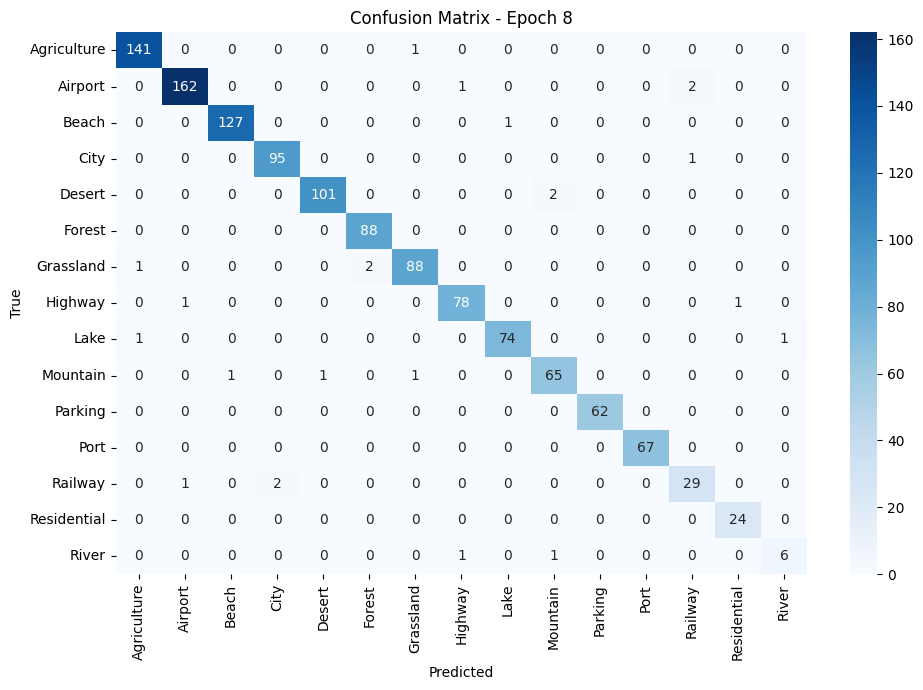

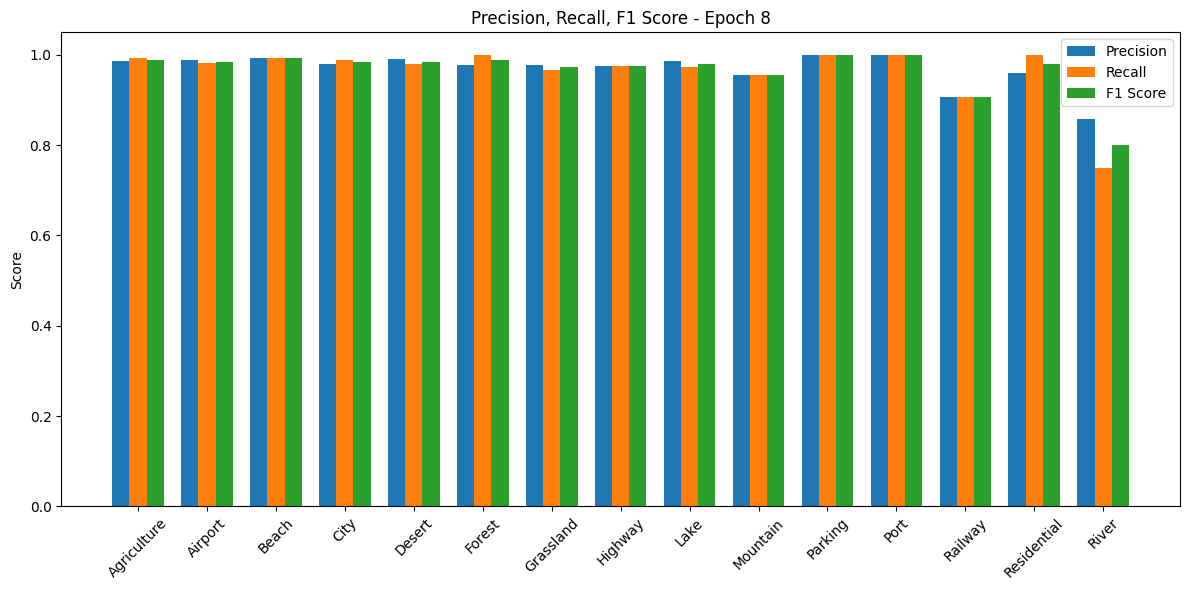

Epoch 9/25: 100%|██████████| 77/77 [00:19<00:00,  4.05it/s]


 Epoch 9/25 - Training Loss: 0.0313



 Classification Report (Epoch 9):
              precision    recall  f1-score   support

 Agriculture       1.00      0.99      0.99       142
     Airport       0.99      0.98      0.98       165
       Beach       0.98      0.99      0.99       128
        City       0.97      0.99      0.98        96
      Desert       0.99      0.95      0.97       103
      Forest       0.98      1.00      0.99        88
   Grassland       0.97      0.96      0.96        91
     Highway       0.97      0.97      0.97        80
        Lake       0.97      0.99      0.98        76
    Mountain       0.90      0.96      0.93        68
     Parking       1.00      1.00      1.00        62
        Port       1.00      1.00      1.00        67
     Railway       0.91      0.91      0.91        32
 Residential       0.96      1.00      0.98        24
       River       1.00      0.75      0.86         8

    accuracy                           0.98      1230
   macro avg       0.97      0.96      0.97  

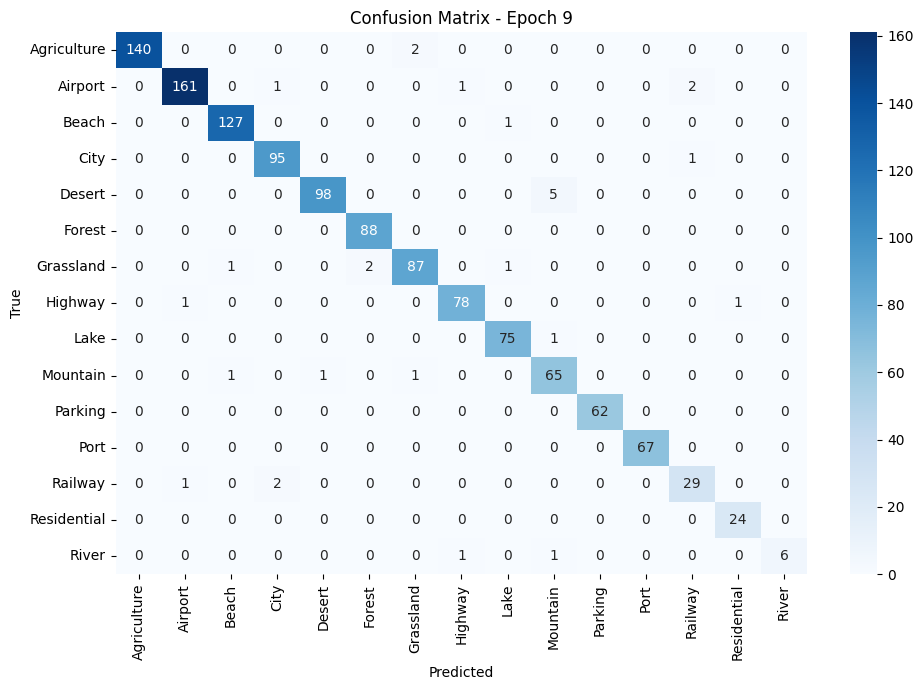

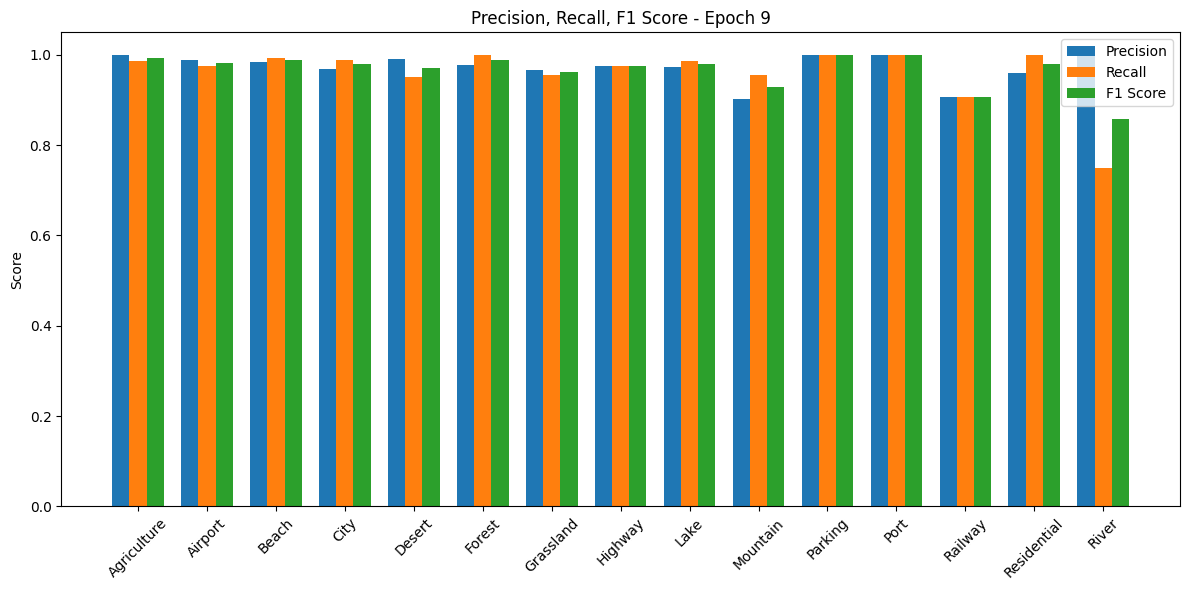

Epoch 10/25: 100%|██████████| 77/77 [00:19<00:00,  3.99it/s]


 Epoch 10/25 - Training Loss: 0.0287



 Classification Report (Epoch 10):
              precision    recall  f1-score   support

 Agriculture       0.99      0.99      0.99       142
     Airport       0.99      0.98      0.98       165
       Beach       0.99      0.98      0.99       128
        City       0.97      0.99      0.98        96
      Desert       0.98      0.99      0.99       103
      Forest       0.98      0.99      0.98        88
   Grassland       0.98      0.96      0.97        91
     Highway       0.99      0.97      0.98        80
        Lake       0.97      0.97      0.97        76
    Mountain       0.97      0.96      0.96        68
     Parking       1.00      1.00      1.00        62
        Port       1.00      1.00      1.00        67
     Railway       0.88      0.91      0.89        32
 Residential       0.96      1.00      0.98        24
       River       0.86      0.75      0.80         8

    accuracy                           0.98      1230
   macro avg       0.97      0.96      0.96 

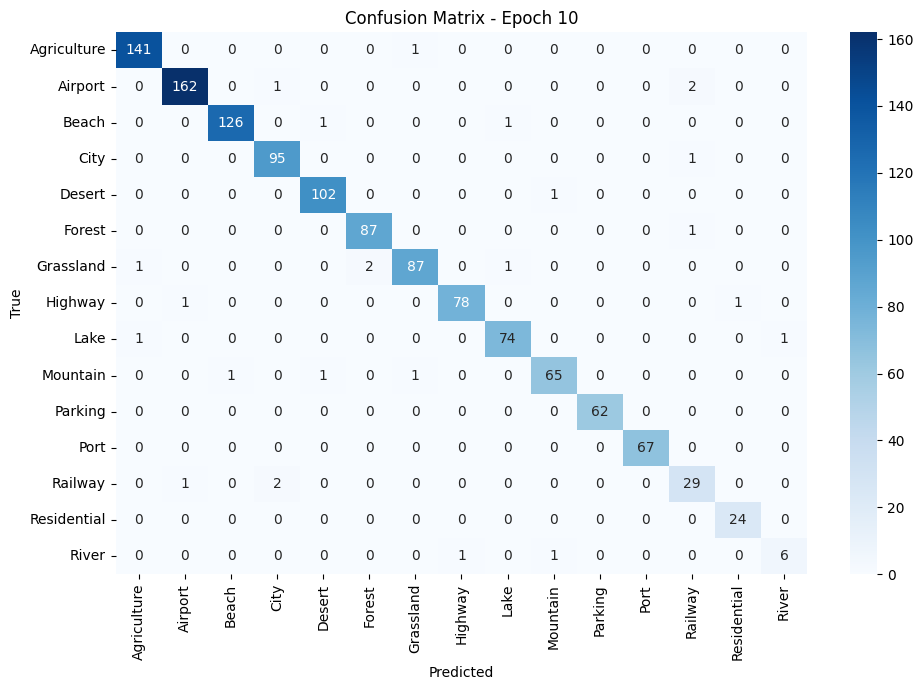

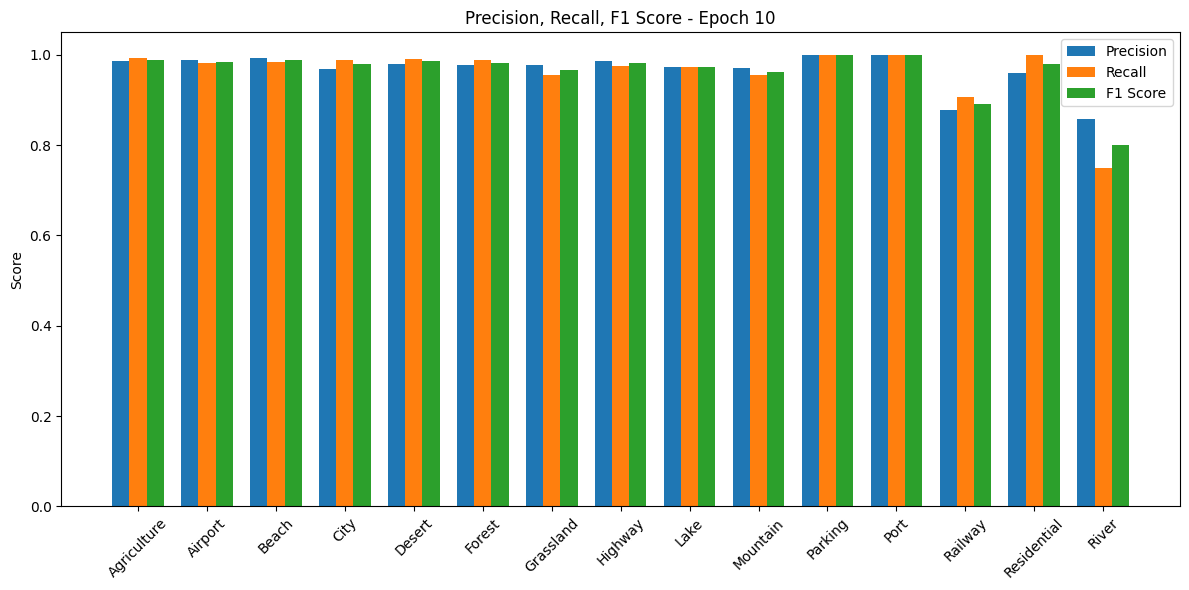

Epoch 11/25: 100%|██████████| 77/77 [00:18<00:00,  4.23it/s]


 Epoch 11/25 - Training Loss: 0.0245



 Classification Report (Epoch 11):
              precision    recall  f1-score   support

 Agriculture       0.99      0.99      0.99       142
     Airport       0.99      0.98      0.98       165
       Beach       1.00      0.99      1.00       128
        City       0.97      0.99      0.98        96
      Desert       0.99      0.97      0.98       103
      Forest       0.98      1.00      0.99        88
   Grassland       0.98      0.96      0.97        91
     Highway       0.99      0.97      0.98        80
        Lake       0.97      0.99      0.98        76
    Mountain       0.93      0.97      0.95        68
     Parking       1.00      1.00      1.00        62
        Port       1.00      1.00      1.00        67
     Railway       0.91      0.91      0.91        32
 Residential       0.96      1.00      0.98        24
       River       1.00      0.75      0.86         8

    accuracy                           0.98      1230
   macro avg       0.98      0.96      0.97 

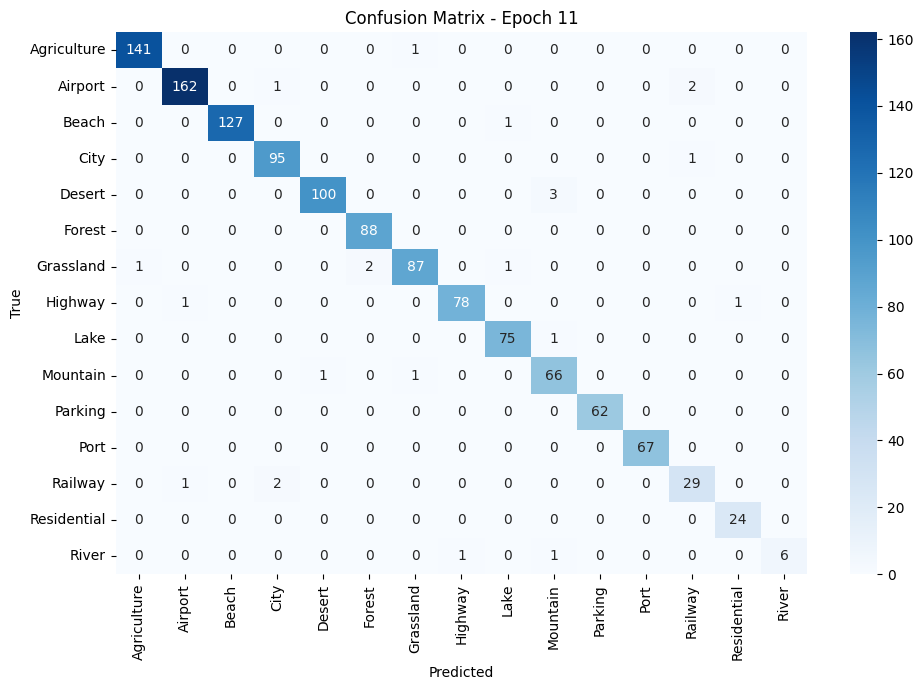

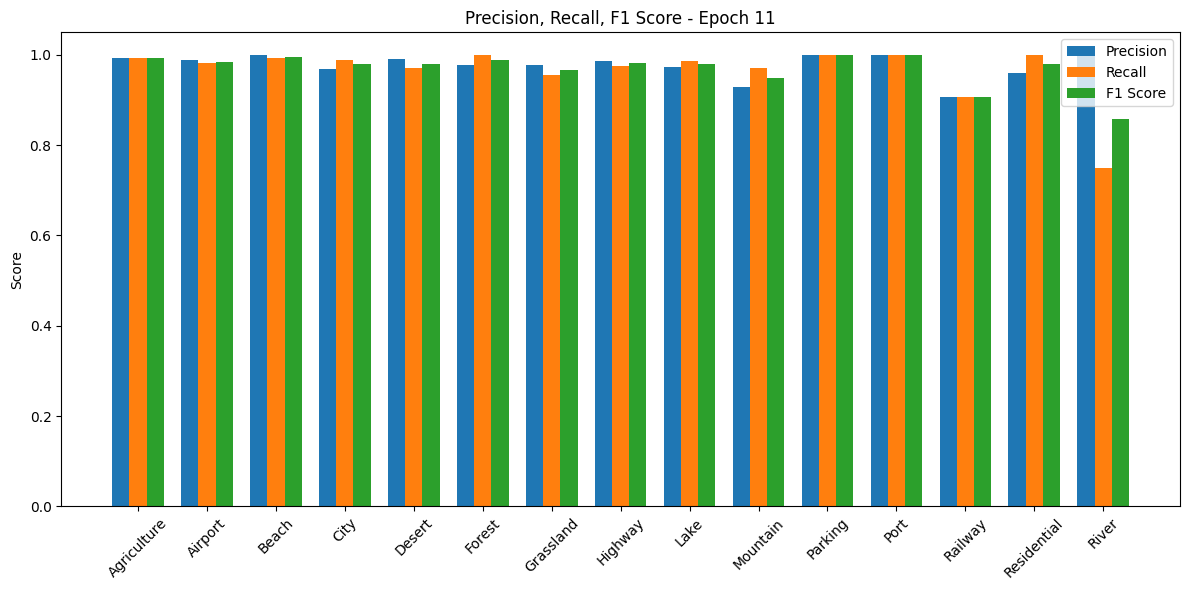

Epoch 12/25: 100%|██████████| 77/77 [00:18<00:00,  4.16it/s]


 Epoch 12/25 - Training Loss: 0.0244



 Classification Report (Epoch 12):
              precision    recall  f1-score   support

 Agriculture       0.99      0.99      0.99       142
     Airport       0.99      0.98      0.98       165
       Beach       0.99      0.98      0.99       128
        City       0.97      0.99      0.98        96
      Desert       0.98      0.97      0.98       103
      Forest       0.98      0.99      0.98        88
   Grassland       0.98      0.95      0.96        91
     Highway       0.99      0.97      0.98        80
        Lake       0.97      0.97      0.97        76
    Mountain       0.93      0.97      0.95        68
     Parking       1.00      1.00      1.00        62
        Port       1.00      1.00      1.00        67
     Railway       0.88      0.91      0.89        32
 Residential       0.96      1.00      0.98        24
       River       1.00      0.75      0.86         8

    accuracy                           0.98      1230
   macro avg       0.97      0.96      0.97 

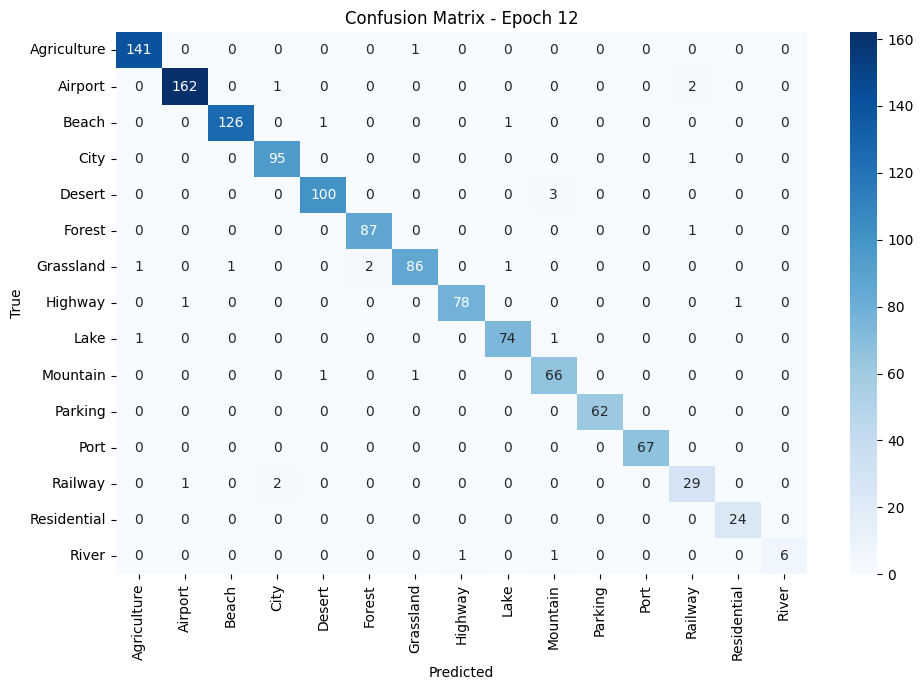

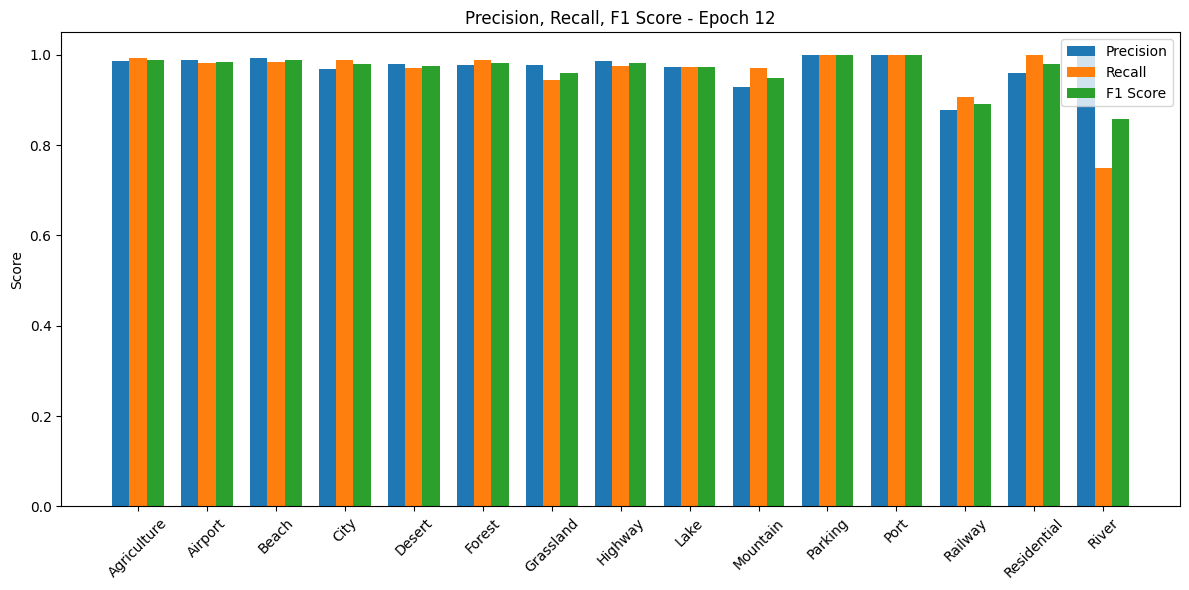

Epoch 13/25: 100%|██████████| 77/77 [00:17<00:00,  4.31it/s]


 Epoch 13/25 - Training Loss: 0.0251



 Classification Report (Epoch 13):
              precision    recall  f1-score   support

 Agriculture       0.99      0.99      0.99       142
     Airport       0.99      0.98      0.99       165
       Beach       0.98      0.99      0.99       128
        City       0.97      0.99      0.98        96
      Desert       0.99      0.99      0.99       103
      Forest       0.98      0.99      0.98        88
   Grassland       0.98      0.95      0.96        91
     Highway       0.99      0.99      0.99        80
        Lake       0.97      0.99      0.98        76
    Mountain       0.96      0.96      0.96        68
     Parking       1.00      1.00      1.00        62
        Port       1.00      1.00      1.00        67
     Railway       0.85      0.91      0.88        32
 Residential       0.96      1.00      0.98        24
       River       1.00      0.75      0.86         8

    accuracy                           0.98      1230
   macro avg       0.97      0.96      0.97 

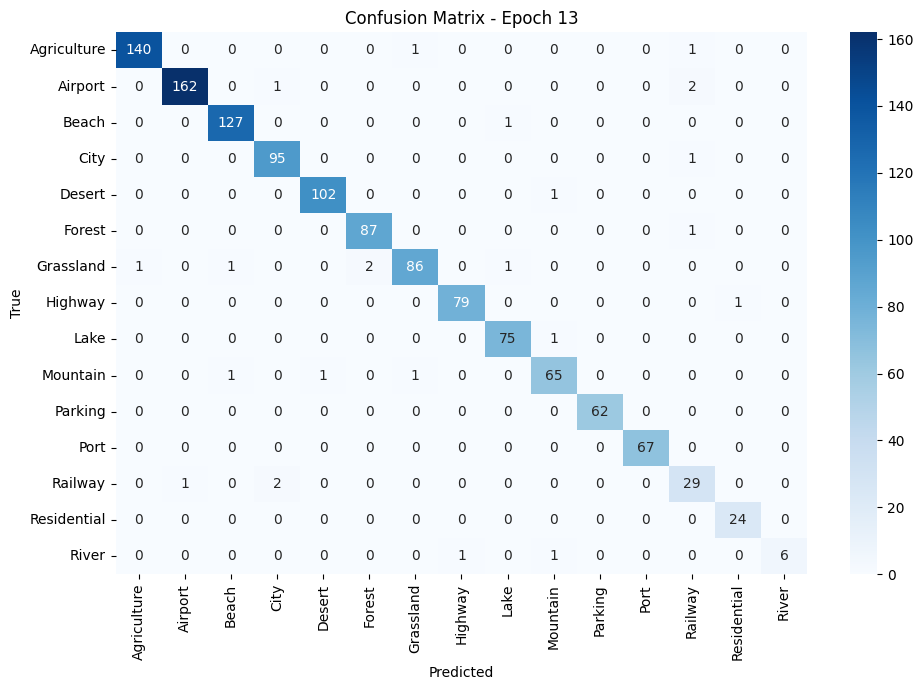

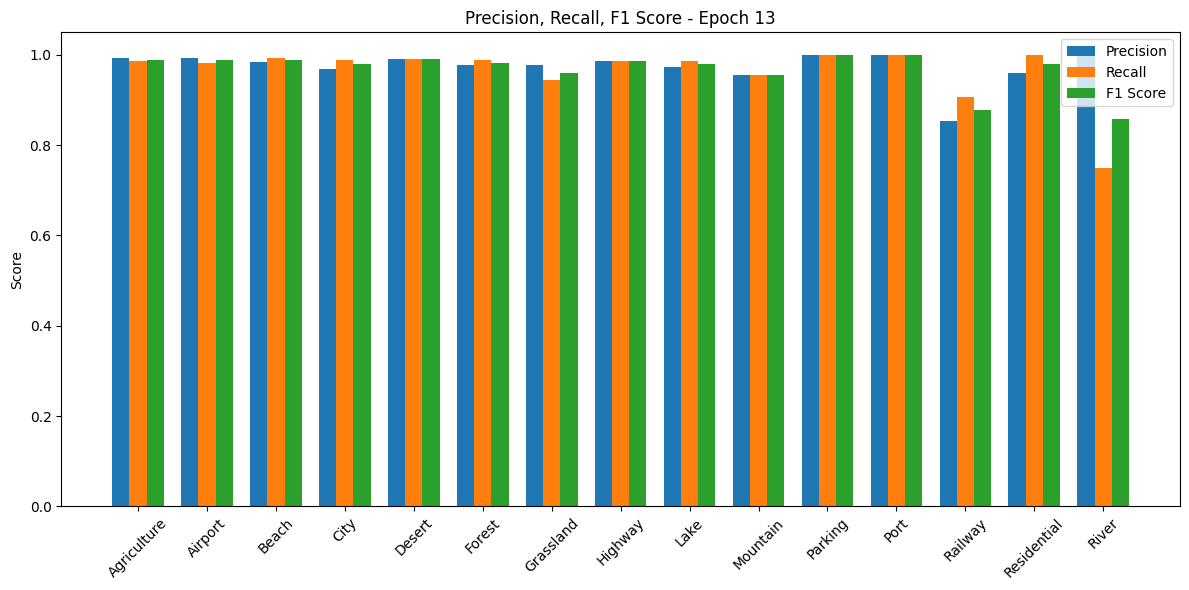

Epoch 14/25: 100%|██████████| 77/77 [00:18<00:00,  4.14it/s]


 Epoch 14/25 - Training Loss: 0.0217



 Classification Report (Epoch 14):
              precision    recall  f1-score   support

 Agriculture       0.99      0.99      0.99       142
     Airport       0.99      0.98      0.99       165
       Beach       0.98      0.99      0.99       128
        City       0.98      0.99      0.98        96
      Desert       0.99      0.99      0.99       103
      Forest       0.98      0.99      0.98        88
   Grassland       0.98      0.96      0.97        91
     Highway       0.96      0.99      0.98        80
        Lake       0.99      0.97      0.98        76
    Mountain       0.97      0.96      0.96        68
     Parking       1.00      1.00      1.00        62
        Port       1.00      1.00      1.00        67
     Railway       0.88      0.91      0.89        32
 Residential       0.96      1.00      0.98        24
       River       0.75      0.75      0.75         8

    accuracy                           0.98      1230
   macro avg       0.96      0.96      0.96 

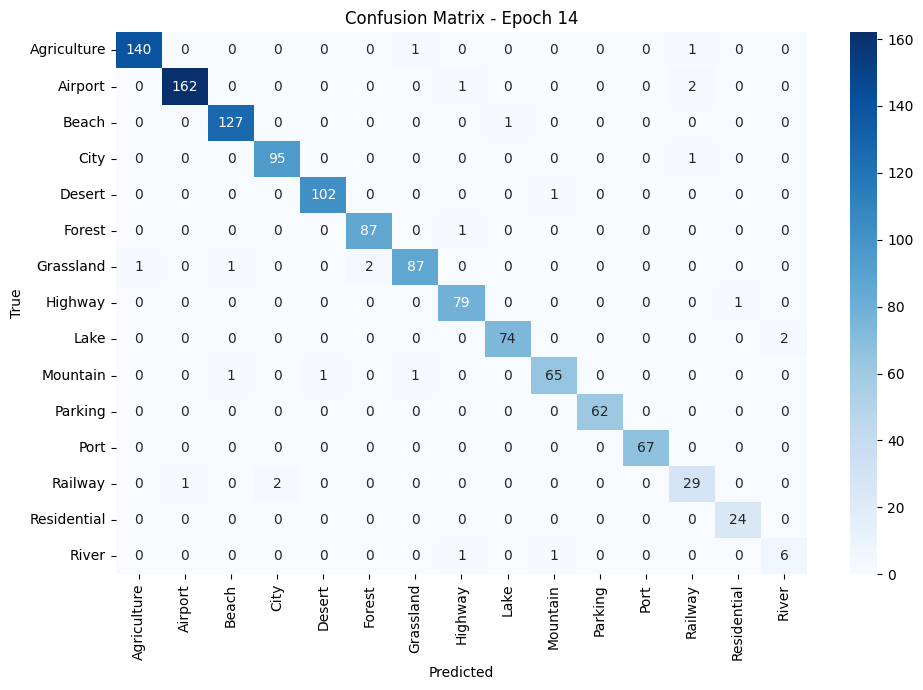

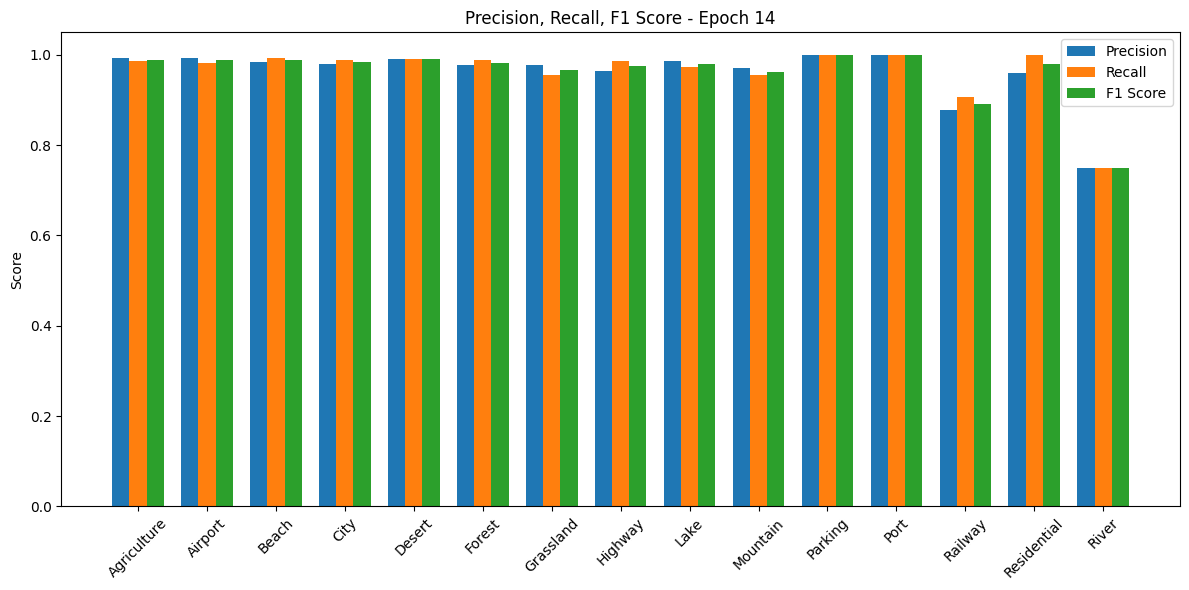

Epoch 15/25: 100%|██████████| 77/77 [00:17<00:00,  4.28it/s]


 Epoch 15/25 - Training Loss: 0.0189



 Classification Report (Epoch 15):
              precision    recall  f1-score   support

 Agriculture       0.99      0.99      0.99       142
     Airport       0.99      0.98      0.99       165
       Beach       0.99      0.99      0.99       128
        City       0.97      0.99      0.98        96
      Desert       0.99      0.99      0.99       103
      Forest       0.98      0.99      0.98        88
   Grassland       0.98      0.95      0.96        91
     Highway       0.99      0.99      0.99        80
        Lake       0.97      0.97      0.97        76
    Mountain       0.97      0.97      0.97        68
     Parking       1.00      1.00      1.00        62
        Port       1.00      1.00      1.00        67
     Railway       0.88      0.91      0.89        32
 Residential       0.96      1.00      0.98        24
       River       0.86      0.75      0.80         8

    accuracy                           0.98      1230
   macro avg       0.97      0.96      0.97 

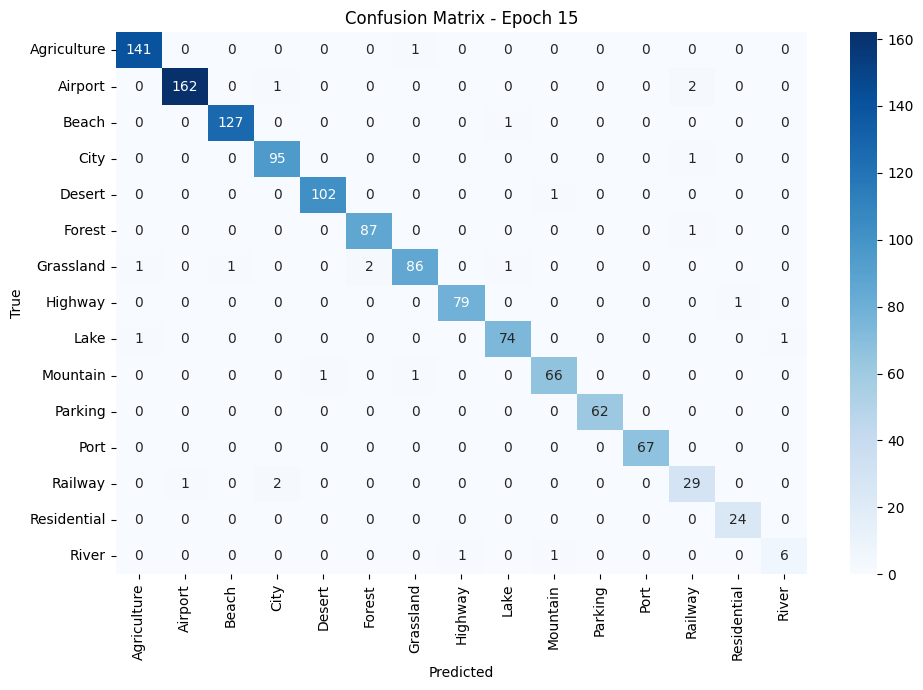

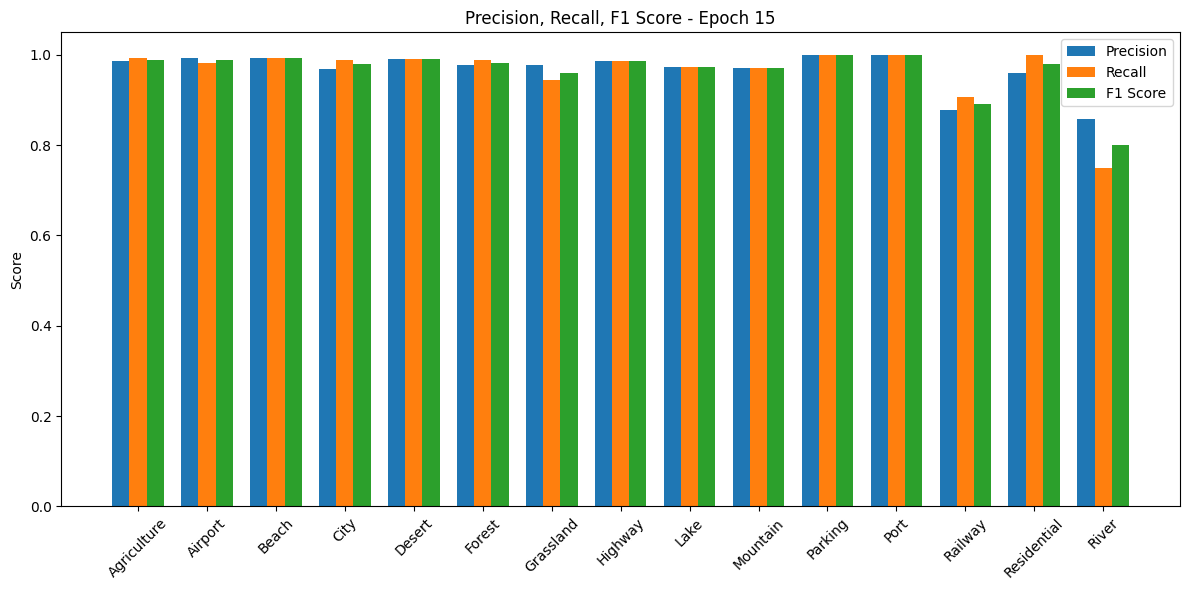

Epoch 16/25: 100%|██████████| 77/77 [00:18<00:00,  4.16it/s]


 Epoch 16/25 - Training Loss: 0.0136



 Classification Report (Epoch 16):
              precision    recall  f1-score   support

 Agriculture       0.99      0.99      0.99       142
     Airport       0.99      0.98      0.98       165
       Beach       0.99      0.99      0.99       128
        City       0.97      0.99      0.98        96
      Desert       0.99      0.99      0.99       103
      Forest       0.98      0.99      0.98        88
   Grassland       0.98      0.95      0.96        91
     Highway       0.98      0.99      0.98        80
        Lake       0.97      0.99      0.98        76
    Mountain       0.97      0.97      0.97        68
     Parking       1.00      1.00      1.00        62
        Port       1.00      1.00      1.00        67
     Railway       0.88      0.91      0.89        32
 Residential       0.96      1.00      0.98        24
       River       0.86      0.75      0.80         8

    accuracy                           0.98      1230
   macro avg       0.97      0.97      0.97 

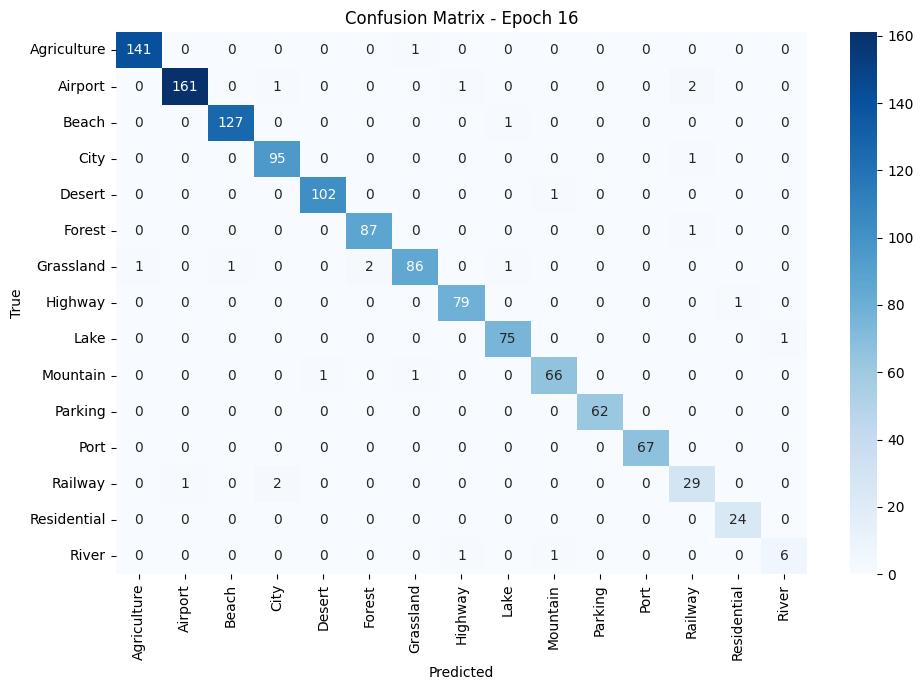

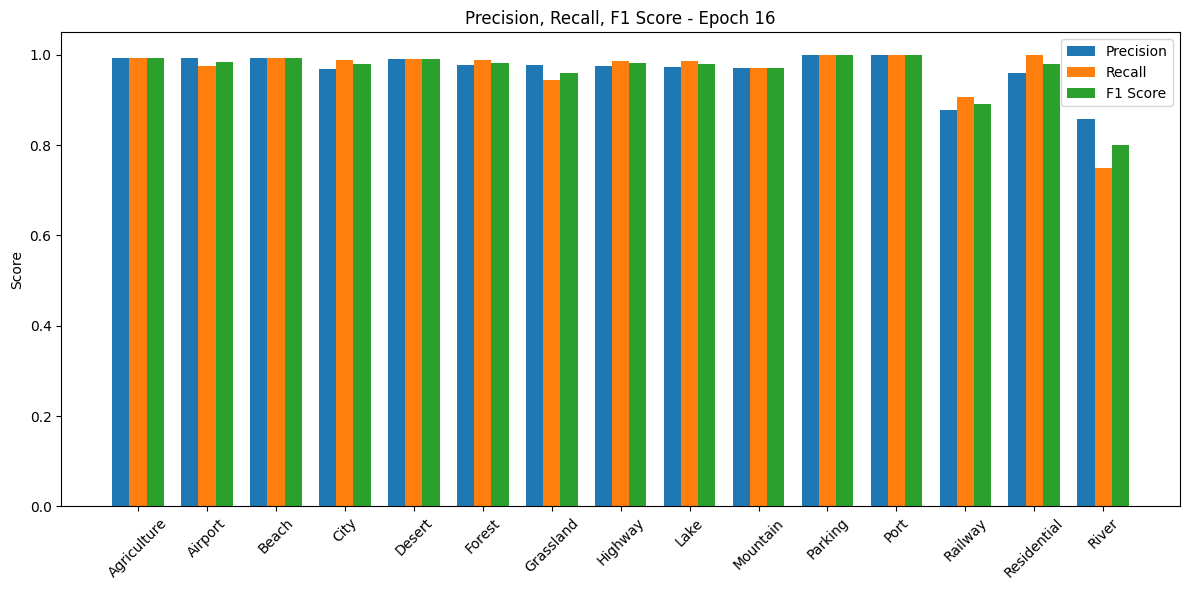

Epoch 17/25: 100%|██████████| 77/77 [00:18<00:00,  4.13it/s]


 Epoch 17/25 - Training Loss: 0.0168



 Classification Report (Epoch 17):
              precision    recall  f1-score   support

 Agriculture       0.99      0.99      0.99       142
     Airport       1.00      0.99      0.99       165
       Beach       0.98      0.99      0.99       128
        City       0.98      0.99      0.98        96
      Desert       0.99      0.99      0.99       103
      Forest       0.99      0.98      0.98        88
   Grassland       0.97      0.96      0.96        91
     Highway       0.99      0.99      0.99        80
        Lake       0.97      0.97      0.97        76
    Mountain       0.96      0.96      0.96        68
     Parking       1.00      1.00      1.00        62
        Port       1.00      1.00      1.00        67
     Railway       0.88      0.94      0.91        32
 Residential       0.96      1.00      0.98        24
       River       1.00      0.75      0.86         8

    accuracy                           0.98      1230
   macro avg       0.98      0.97      0.97 

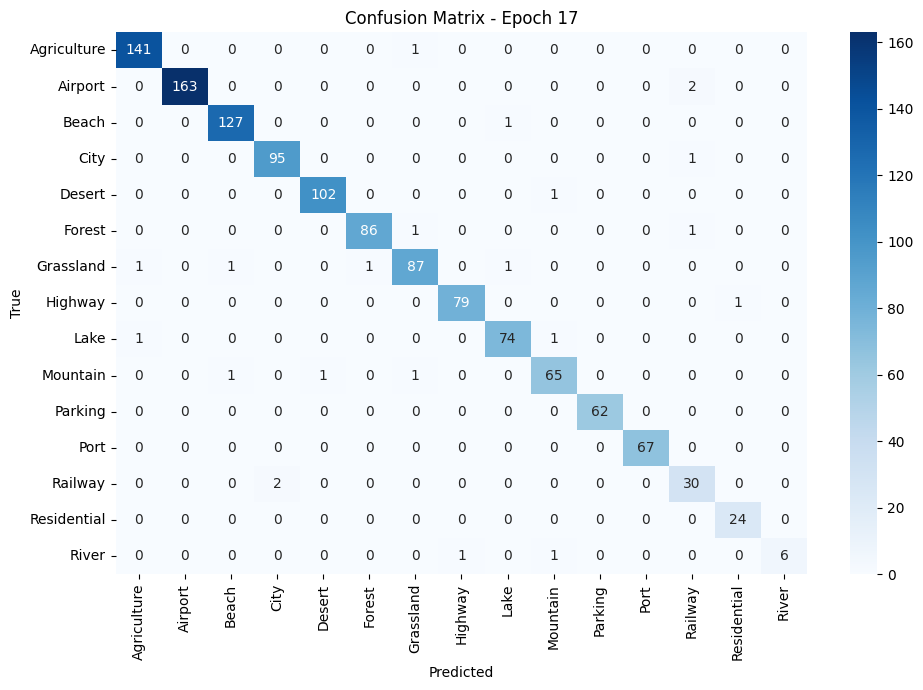

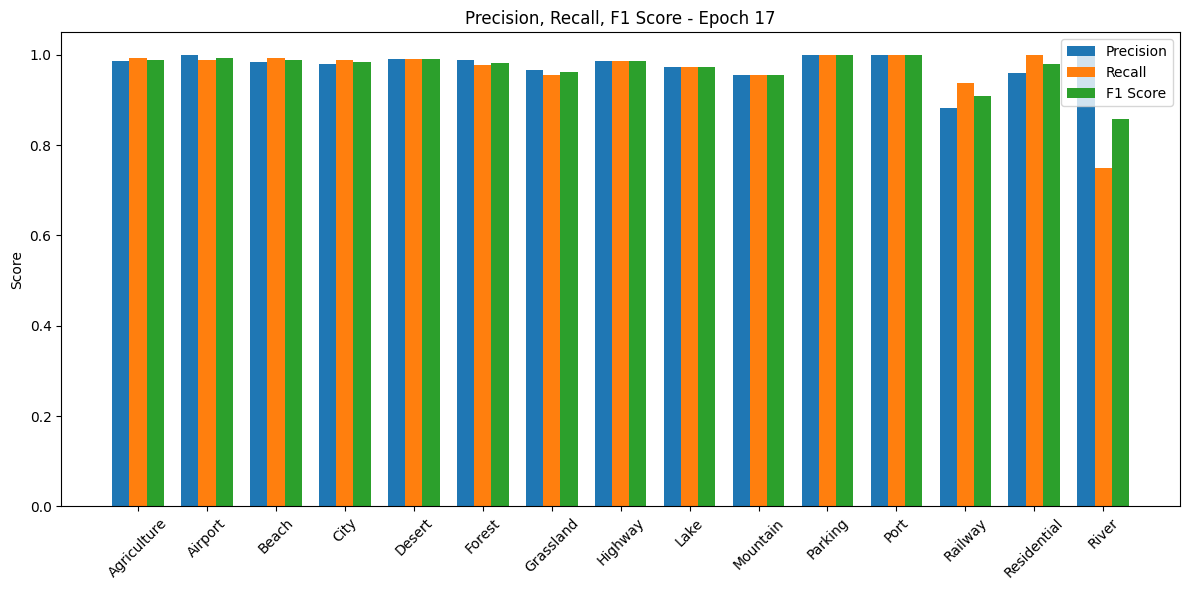

Epoch 18/25: 100%|██████████| 77/77 [00:18<00:00,  4.23it/s]


 Epoch 18/25 - Training Loss: 0.0136



 Classification Report (Epoch 18):
              precision    recall  f1-score   support

 Agriculture       0.99      1.00      0.99       142
     Airport       0.96      0.99      0.98       165
       Beach       0.99      0.98      0.99       128
        City       0.97      0.99      0.98        96
      Desert       0.98      0.99      0.99       103
      Forest       0.98      0.99      0.98        88
   Grassland       0.99      0.92      0.95        91
     Highway       0.99      0.97      0.98        80
        Lake       0.97      0.97      0.97        76
    Mountain       0.96      0.97      0.96        68
     Parking       1.00      1.00      1.00        62
        Port       1.00      1.00      1.00        67
     Railway       0.91      0.91      0.91        32
 Residential       0.96      0.96      0.96        24
       River       1.00      0.62      0.77         8

    accuracy                           0.98      1230
   macro avg       0.98      0.95      0.96 

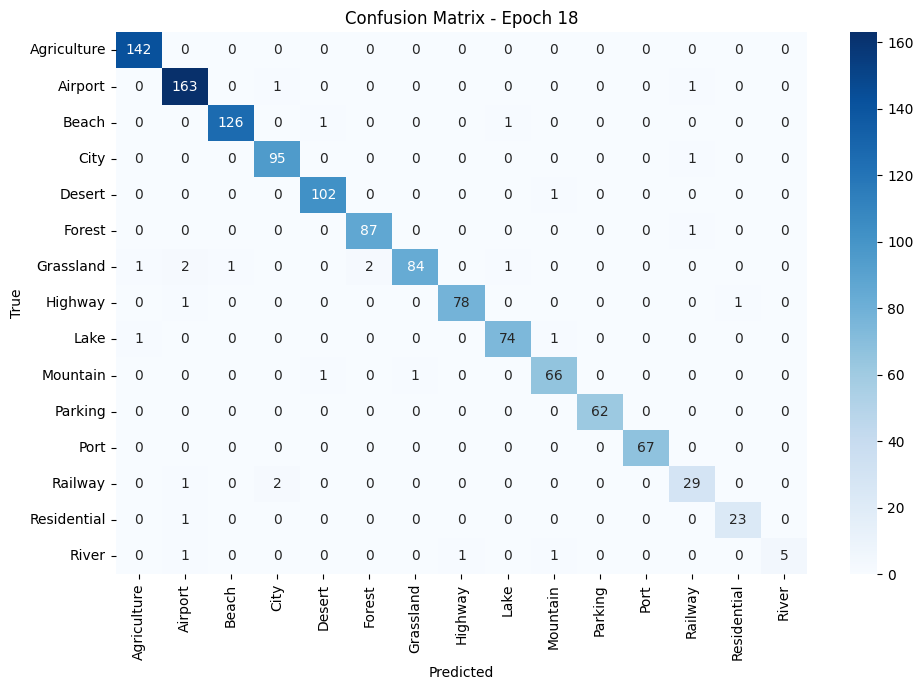

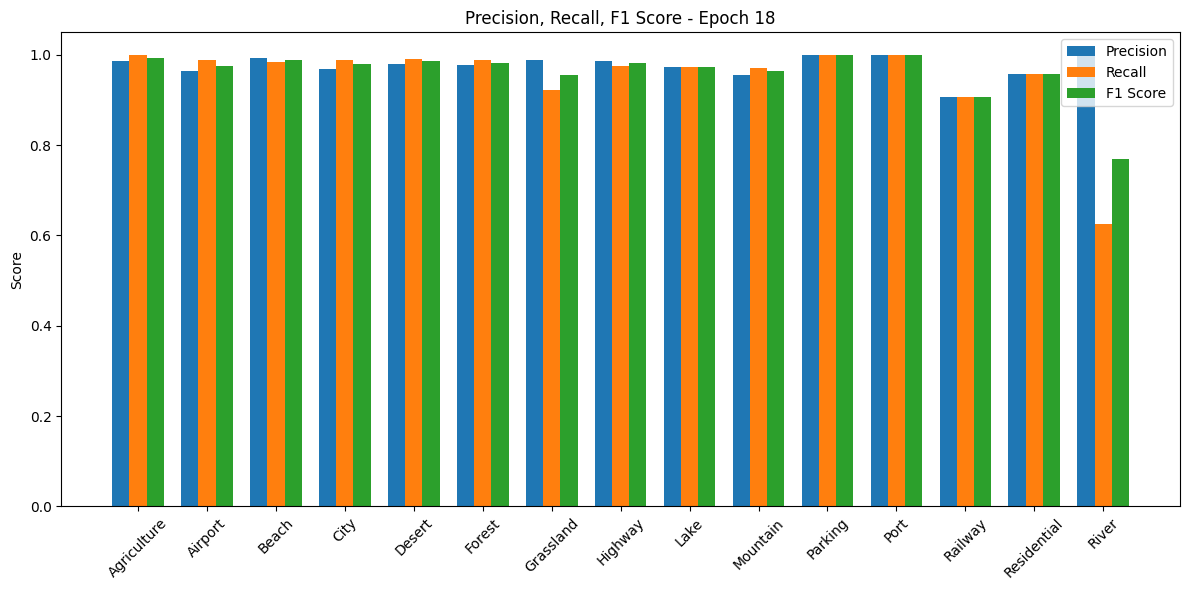

Epoch 19/25: 100%|██████████| 77/77 [00:18<00:00,  4.10it/s]


 Epoch 19/25 - Training Loss: 0.0154



 Classification Report (Epoch 19):
              precision    recall  f1-score   support

 Agriculture       0.99      0.99      0.99       142
     Airport       0.98      0.99      0.98       165
       Beach       0.98      0.99      0.99       128
        City       0.97      0.99      0.98        96
      Desert       0.99      0.98      0.99       103
      Forest       0.99      0.99      0.99        88
   Grassland       0.98      0.96      0.97        91
     Highway       0.99      0.97      0.98        80
        Lake       0.97      0.97      0.97        76
    Mountain       0.94      0.96      0.95        68
     Parking       1.00      1.00      1.00        62
        Port       1.00      1.00      1.00        67
     Railway       0.91      0.91      0.91        32
 Residential       0.96      0.96      0.96        24
       River       1.00      0.62      0.77         8

    accuracy                           0.98      1230
   macro avg       0.98      0.95      0.96 

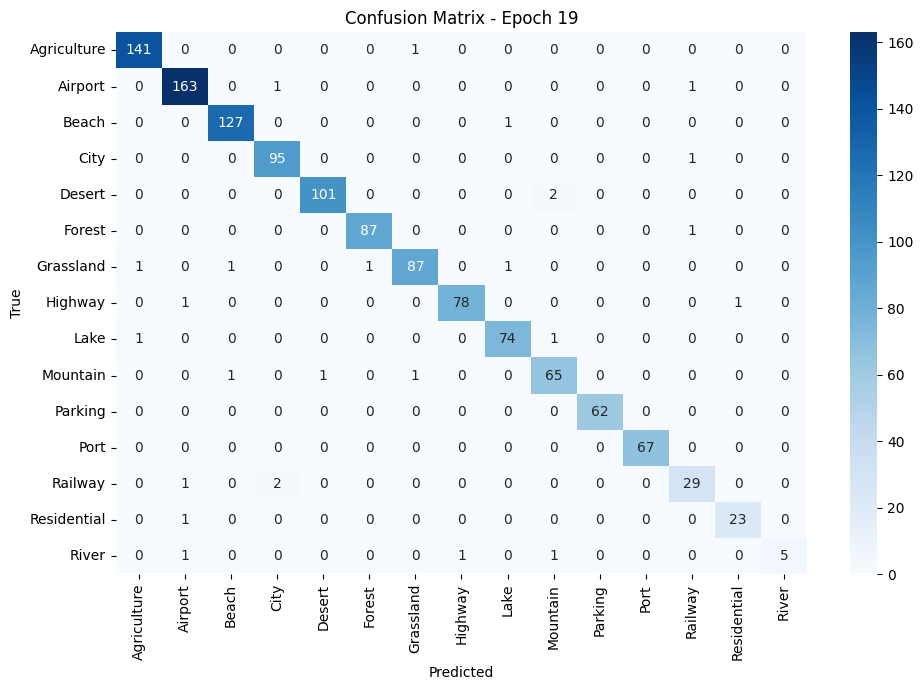

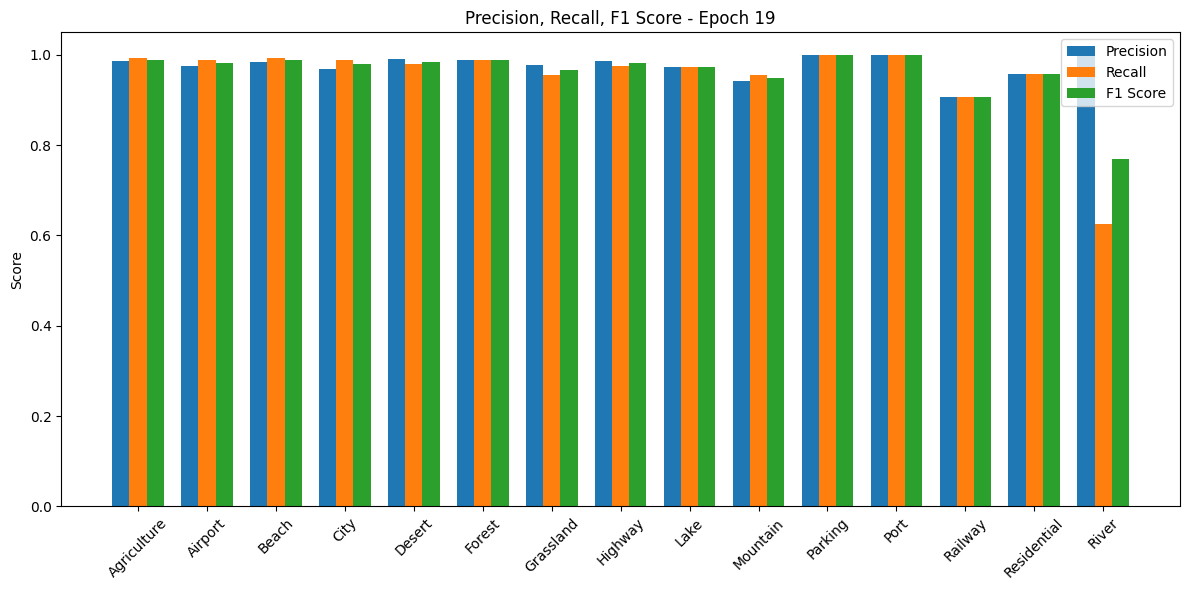

Epoch 20/25: 100%|██████████| 77/77 [00:18<00:00,  4.25it/s]


 Epoch 20/25 - Training Loss: 0.0119



 Classification Report (Epoch 20):
              precision    recall  f1-score   support

 Agriculture       0.99      0.99      0.99       142
     Airport       0.99      0.98      0.98       165
       Beach       0.99      0.99      0.99       128
        City       0.97      0.99      0.98        96
      Desert       0.99      0.99      0.99       103
      Forest       0.99      0.99      0.99        88
   Grassland       0.98      0.97      0.97        91
     Highway       0.98      0.99      0.98        80
        Lake       0.97      0.97      0.97        76
    Mountain       0.96      0.96      0.96        68
     Parking       1.00      1.00      1.00        62
        Port       1.00      1.00      1.00        67
     Railway       0.88      0.91      0.89        32
 Residential       0.96      1.00      0.98        24
       River       1.00      0.75      0.86         8

    accuracy                           0.98      1230
   macro avg       0.98      0.96      0.97 

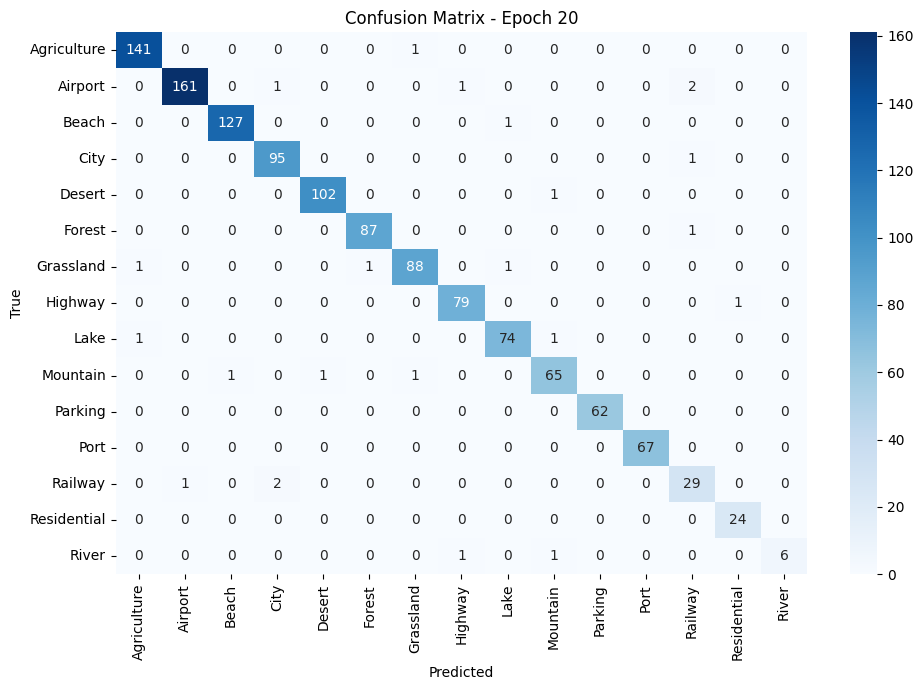

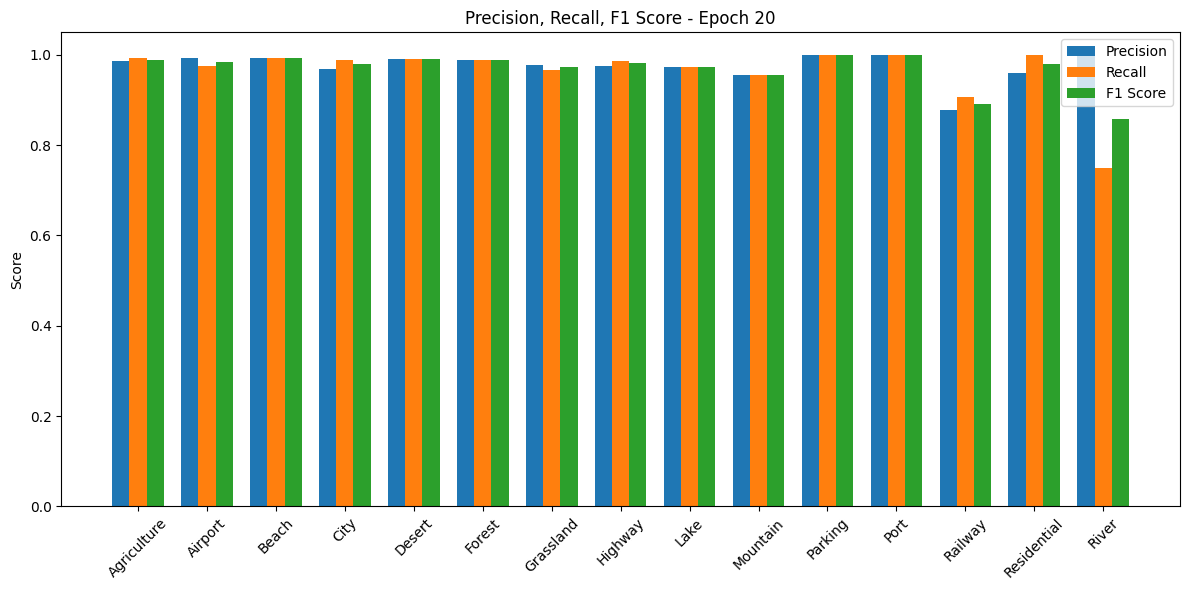

Epoch 21/25: 100%|██████████| 77/77 [00:18<00:00,  4.25it/s]


 Epoch 21/25 - Training Loss: 0.0114



 Classification Report (Epoch 21):
              precision    recall  f1-score   support

 Agriculture       0.99      0.99      0.99       142
     Airport       0.99      0.99      0.99       165
       Beach       0.99      0.99      0.99       128
        City       0.97      0.99      0.98        96
      Desert       0.99      0.99      0.99       103
      Forest       0.99      0.99      0.99        88
   Grassland       0.98      0.96      0.97        91
     Highway       0.99      0.97      0.98        80
        Lake       0.97      0.97      0.97        76
    Mountain       0.96      0.97      0.96        68
     Parking       1.00      1.00      1.00        62
        Port       1.00      1.00      1.00        67
     Railway       0.91      0.91      0.91        32
 Residential       0.96      1.00      0.98        24
       River       1.00      0.75      0.86         8

    accuracy                           0.98      1230
   macro avg       0.98      0.96      0.97 

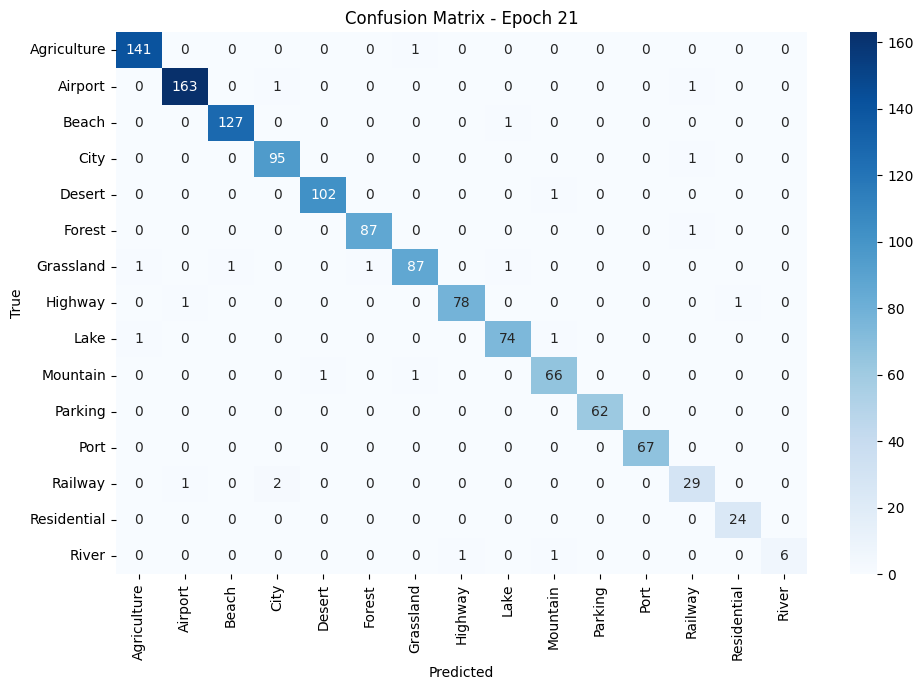

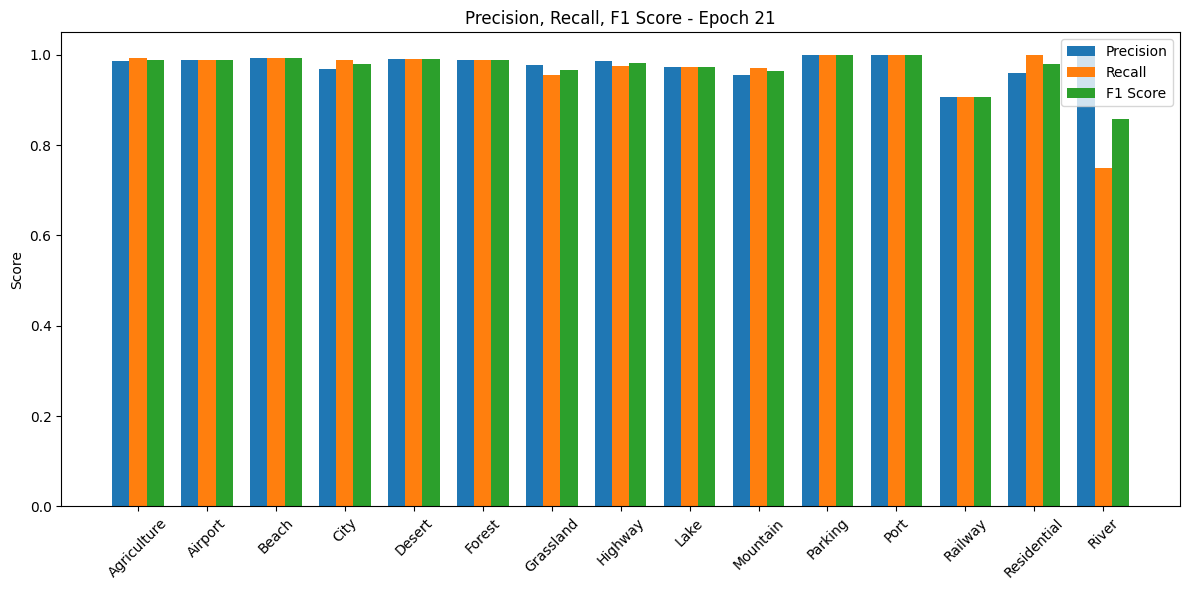

Epoch 22/25: 100%|██████████| 77/77 [00:18<00:00,  4.07it/s]


 Epoch 22/25 - Training Loss: 0.0117



 Classification Report (Epoch 22):
              precision    recall  f1-score   support

 Agriculture       0.98      0.99      0.99       142
     Airport       0.99      0.99      0.99       165
       Beach       0.99      0.99      0.99       128
        City       0.98      1.00      0.99        96
      Desert       0.99      0.99      0.99       103
      Forest       0.98      0.99      0.98        88
   Grassland       0.98      0.95      0.96        91
     Highway       0.97      0.97      0.97        80
        Lake       0.97      0.97      0.97        76
    Mountain       0.97      0.96      0.96        68
     Parking       1.00      1.00      1.00        62
        Port       1.00      1.00      1.00        67
     Railway       0.94      0.91      0.92        32
 Residential       0.96      1.00      0.98        24
       River       0.86      0.75      0.80         8

    accuracy                           0.98      1230
   macro avg       0.97      0.96      0.97 

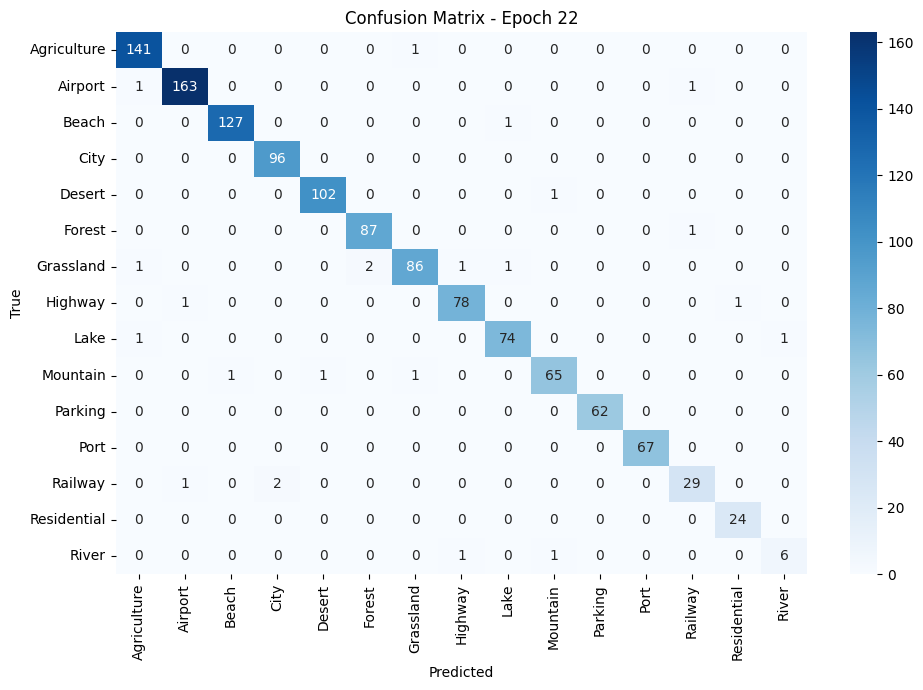

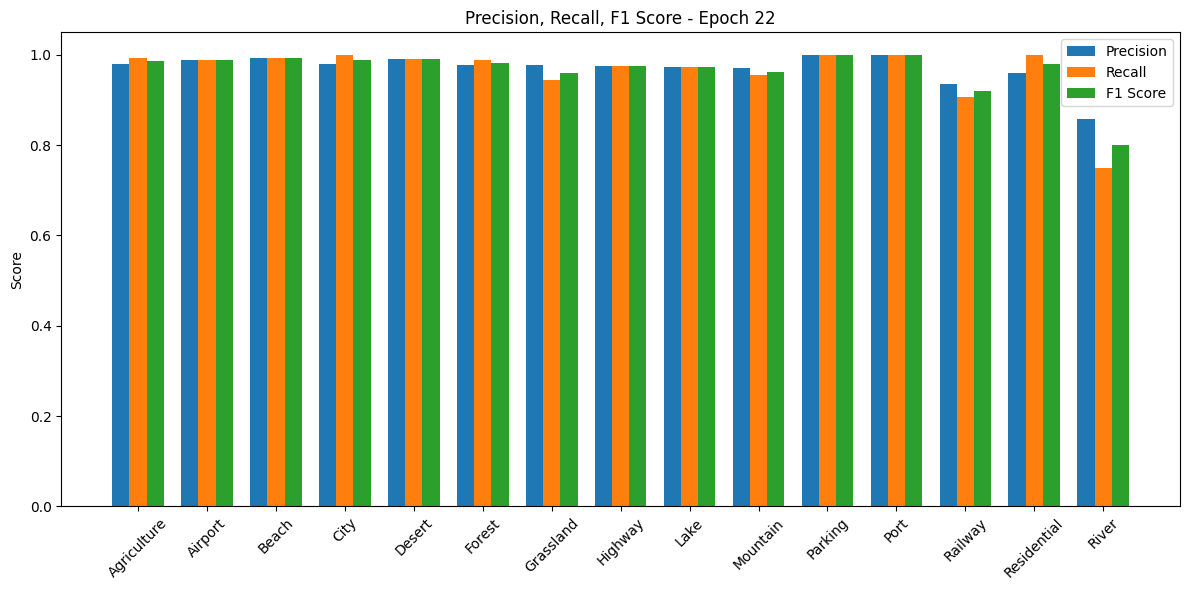

Epoch 23/25: 100%|██████████| 77/77 [00:19<00:00,  3.91it/s]


 Epoch 23/25 - Training Loss: 0.0102



 Classification Report (Epoch 23):
              precision    recall  f1-score   support

 Agriculture       0.99      0.99      0.99       142
     Airport       0.99      0.99      0.99       165
       Beach       0.99      0.99      0.99       128
        City       0.98      0.99      0.98        96
      Desert       0.99      0.99      0.99       103
      Forest       0.98      0.99      0.98        88
   Grassland       0.98      0.96      0.97        91
     Highway       0.99      0.97      0.98        80
        Lake       0.97      1.00      0.99        76
    Mountain       0.97      0.96      0.96        68
     Parking       1.00      1.00      1.00        62
        Port       1.00      1.00      1.00        67
     Railway       0.88      0.91      0.89        32
 Residential       0.96      1.00      0.98        24
       River       1.00      0.75      0.86         8

    accuracy                           0.98      1230
   macro avg       0.98      0.97      0.97 

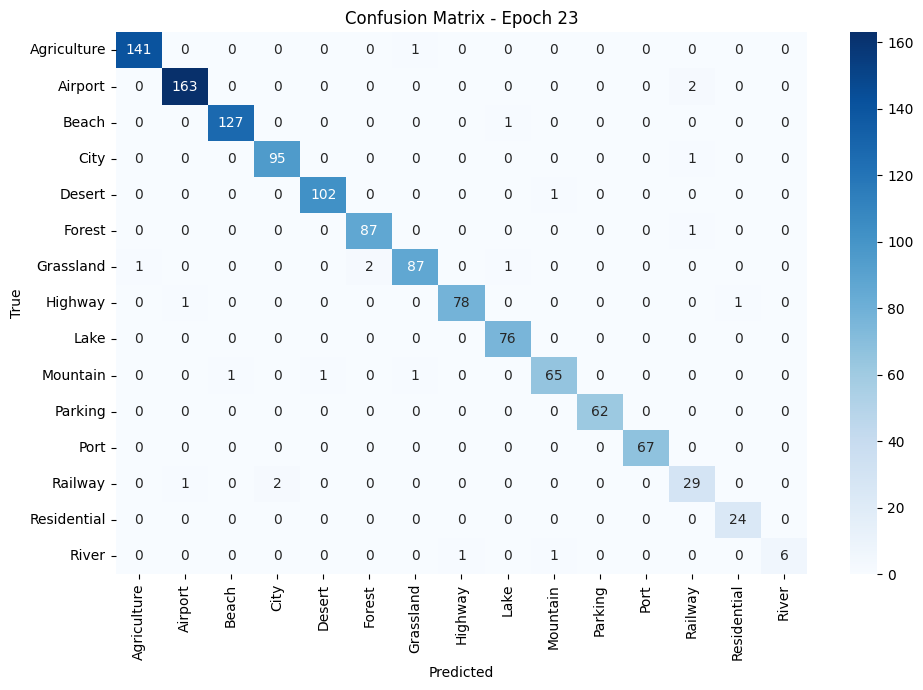

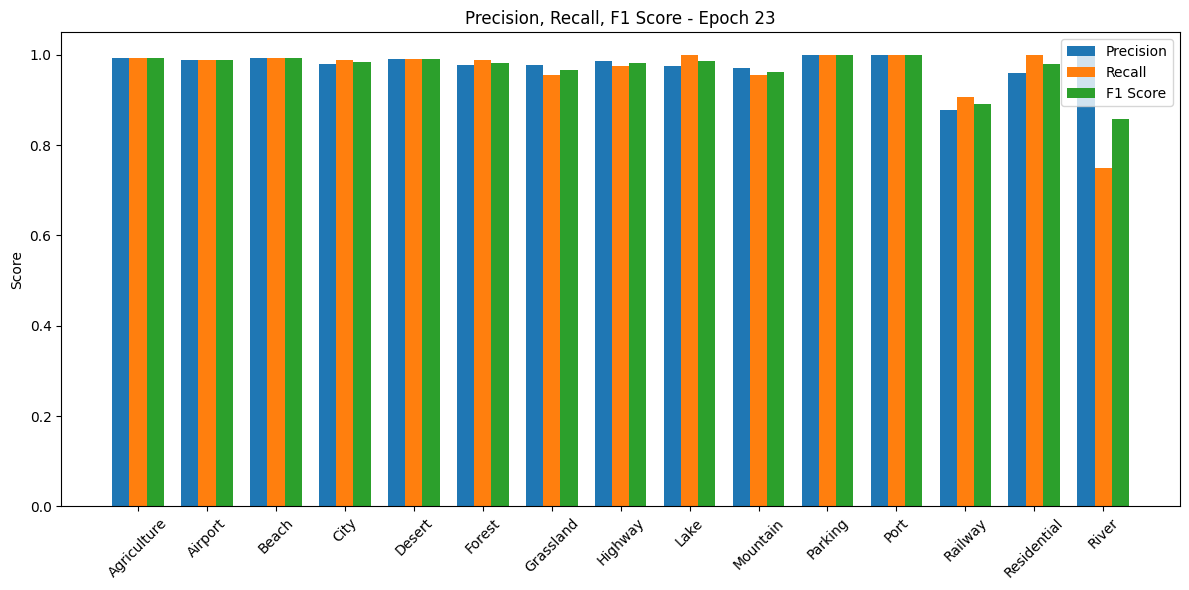

Epoch 24/25: 100%|██████████| 77/77 [00:18<00:00,  4.09it/s]


 Epoch 24/25 - Training Loss: 0.0096



 Classification Report (Epoch 24):
              precision    recall  f1-score   support

 Agriculture       0.99      0.99      0.99       142
     Airport       0.99      0.99      0.99       165
       Beach       1.00      0.99      1.00       128
        City       0.97      1.00      0.98        96
      Desert       0.99      0.98      0.99       103
      Forest       0.98      0.99      0.98        88
   Grassland       0.98      0.96      0.97        91
     Highway       0.99      0.97      0.98        80
        Lake       0.97      0.99      0.98        76
    Mountain       0.96      0.97      0.96        68
     Parking       1.00      1.00      1.00        62
        Port       1.00      1.00      1.00        67
     Railway       0.94      0.91      0.92        32
 Residential       0.96      1.00      0.98        24
       River       0.86      0.75      0.80         8

    accuracy                           0.98      1230
   macro avg       0.97      0.97      0.97 

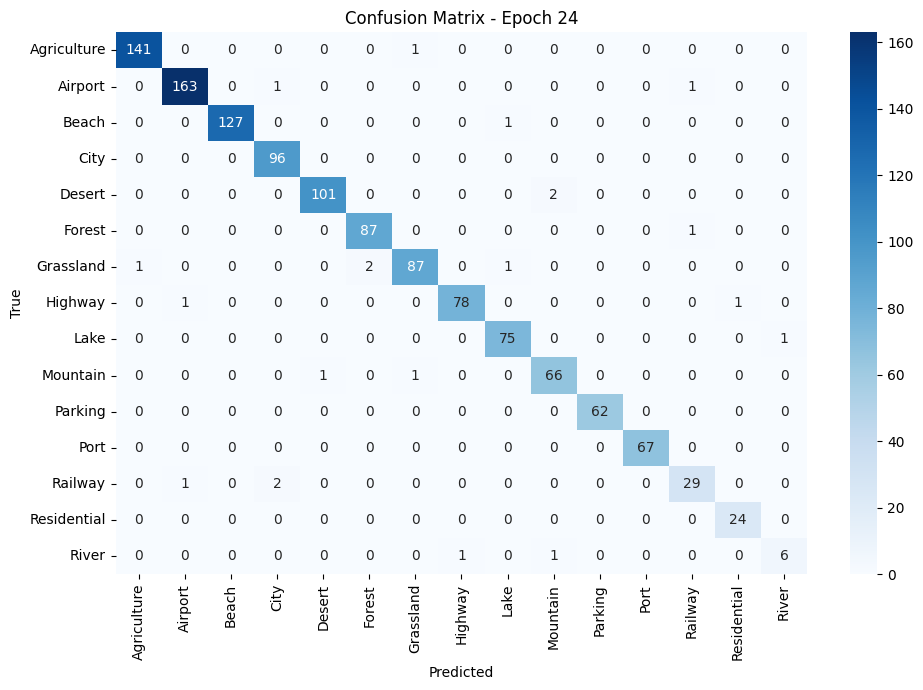

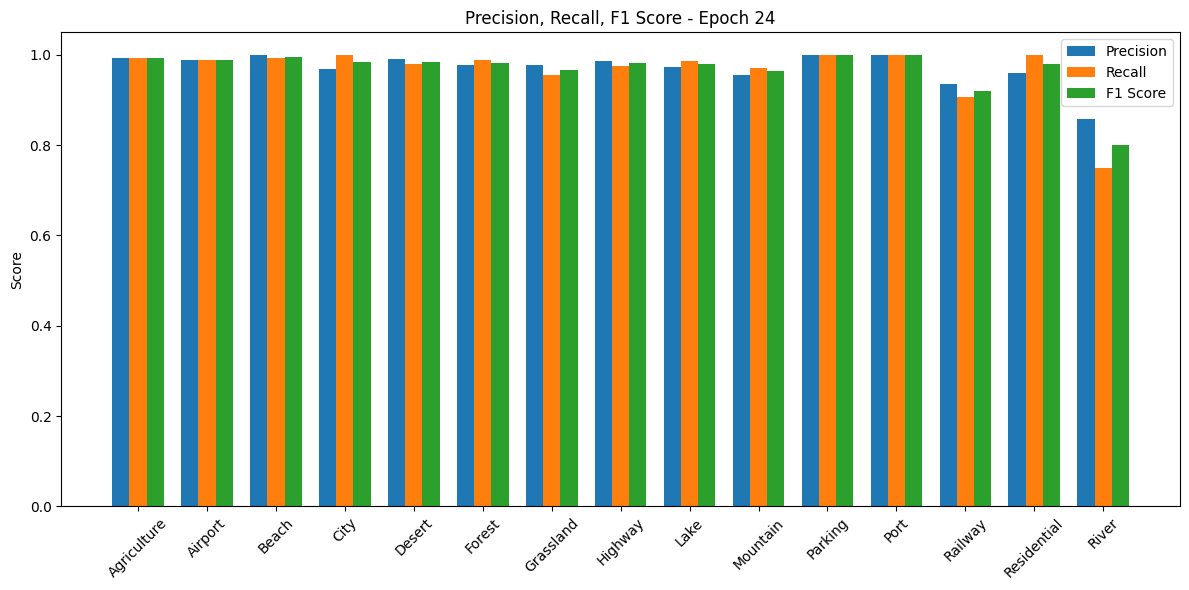

Epoch 25/25: 100%|██████████| 77/77 [00:18<00:00,  4.18it/s]


 Epoch 25/25 - Training Loss: 0.0085



 Classification Report (Epoch 25):
              precision    recall  f1-score   support

 Agriculture       0.99      0.99      0.99       142
     Airport       0.99      0.99      0.99       165
       Beach       1.00      0.98      0.99       128
        City       0.98      0.99      0.98        96
      Desert       0.98      0.99      0.99       103
      Forest       0.98      0.99      0.98        88
   Grassland       0.98      0.95      0.96        91
     Highway       0.97      0.97      0.97        80
        Lake       0.97      0.99      0.98        76
    Mountain       0.97      0.97      0.97        68
     Parking       1.00      1.00      1.00        62
        Port       1.00      1.00      1.00        67
     Railway       0.88      0.91      0.89        32
 Residential       0.96      1.00      0.98        24
       River       0.86      0.75      0.80         8

    accuracy                           0.98      1230
   macro avg       0.97      0.96      0.97 

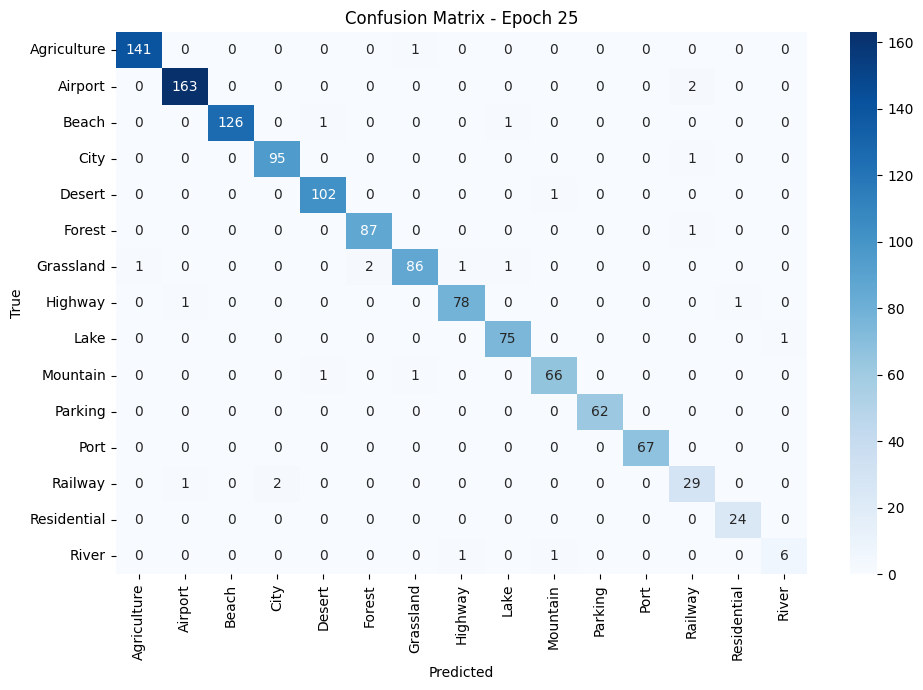

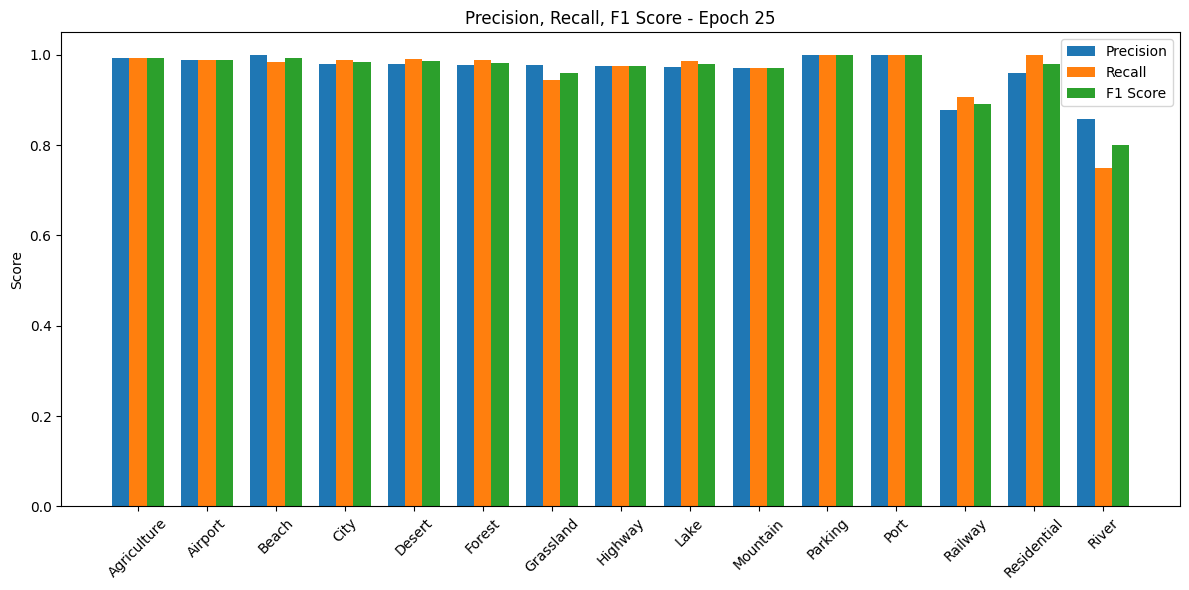

In [ ]:
#  Training + Evaluation
def plot_confusion_and_metrics(y_true, y_pred, class_names, epoch):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap="Blues")
    plt.title(f"Confusion Matrix - Epoch {epoch+1}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, zero_division=0)
    x = range(len(class_names))
    width = 0.25
    plt.figure(figsize=(12, 6))
    plt.bar([p - width for p in x], precision, width, label='Precision')
    plt.bar(x, recall, width, label='Recall')
    plt.bar([p + width for p in x], f1, width, label='F1 Score')
    plt.xticks(ticks=x, labels=class_names, rotation=45)
    plt.ylabel('Score')
    plt.title(f'Precision, Recall, F1 Score - Epoch {epoch+1}')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Main training loop
for epoch in range(EPOCHS):
    efficientnet.train()
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = efficientnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"\n Epoch {epoch+1}/{EPOCHS} - Training Loss: {avg_loss:.4f}")
    scheduler.step()

    # Evaluation
    efficientnet.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = efficientnet(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print(f"\n Classification Report (Epoch {epoch+1}):")
    print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))
    plot_confusion_and_metrics(all_labels, all_preds, class_names, epoch)